In [38]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

import emcee

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as random
import jax.numpy as jnp
from jax.lax import cond
from jax import jit, hessian, vmap

import jaxopt

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import getdist
import getdist.plots

from bayesian_stats_course_tools.analyse import plot_data, analyse_data

import warnings
warnings.filterwarnings('ignore')

In [2]:
title = "# Working with posteriors and model checking"
# Print title and setup TeX defs for both KaTeX and MathJax
import bayesian_stats_course_tools
bayesian_stats_course_tools.misc.display_markdown_and_setup_tex(title)

import matplotlib.style
matplotlib.style.use("bayesian_stats_course_tools.light")

# Working with posteriors and model checking

<!-- Define LaTeX macros -->
$\def\E{\operatorname{E}}$
$\def\Var{\operatorname{Var}}$
$\def\Cov{\operatorname{Cov}}$
$\def\dd{\mathrm{d}}$
$\def\ee{\mathrm{e}}$
$\def\Norm{\mathcal{N}}$
$\def\Uniform{\mathcal{U}}$

<!-- MathJax needs them to be defined again for the non-inline environment -->
$$\def\E{\operatorname{E}}$$
$$\def\Var{\operatorname{Var}}$$
$$\def\Cov{\operatorname{Cov}}$$
$$\def\dd{\mathrm{d}}$$
$$\def\ee{\mathrm{e}}$$
$$\def\Norm{\mathcal{N}}$$
$$\def\Uniform{\mathcal{U}}$$

## Checking MCMC outputs

We spent the last two lectures on sampling algorithms. But how do we check that their outputs actually sample from our target distribution?

- Trace plots
- Auto-correlation time/number of effective samples
- If applicable: Gelman-Rubin $\hat R$ statistic

### Trace plots

Plot the value of each parameter in the chain(s) vs iteration.

A simple visualisation that can flag many common issues, like burn-in, poor mixing, non-stationarity, etc.

In [28]:
import emcee

n_walker = 9
n_param = 3
param_names = ["Omega_m", "H0", "M"]

# Here we read a file with a chain that was run before
chain_per_walker = np.load("data/mcmc_data/emcee_chain.npy")
assert chain_per_walker.shape == (5000, 9, 3)

Imagine we ran an MCMC with `emcee` (the super nova example in this case):

In [ ]:
sampler = emcee.EnsembleSampler(
    nwalkers=n_walker, ndim=n_param,
    ...
)
state = sampler.run_mcmc(...)
chain_per_walker = state.get_chain()

The trace plot of this chain looks like this:

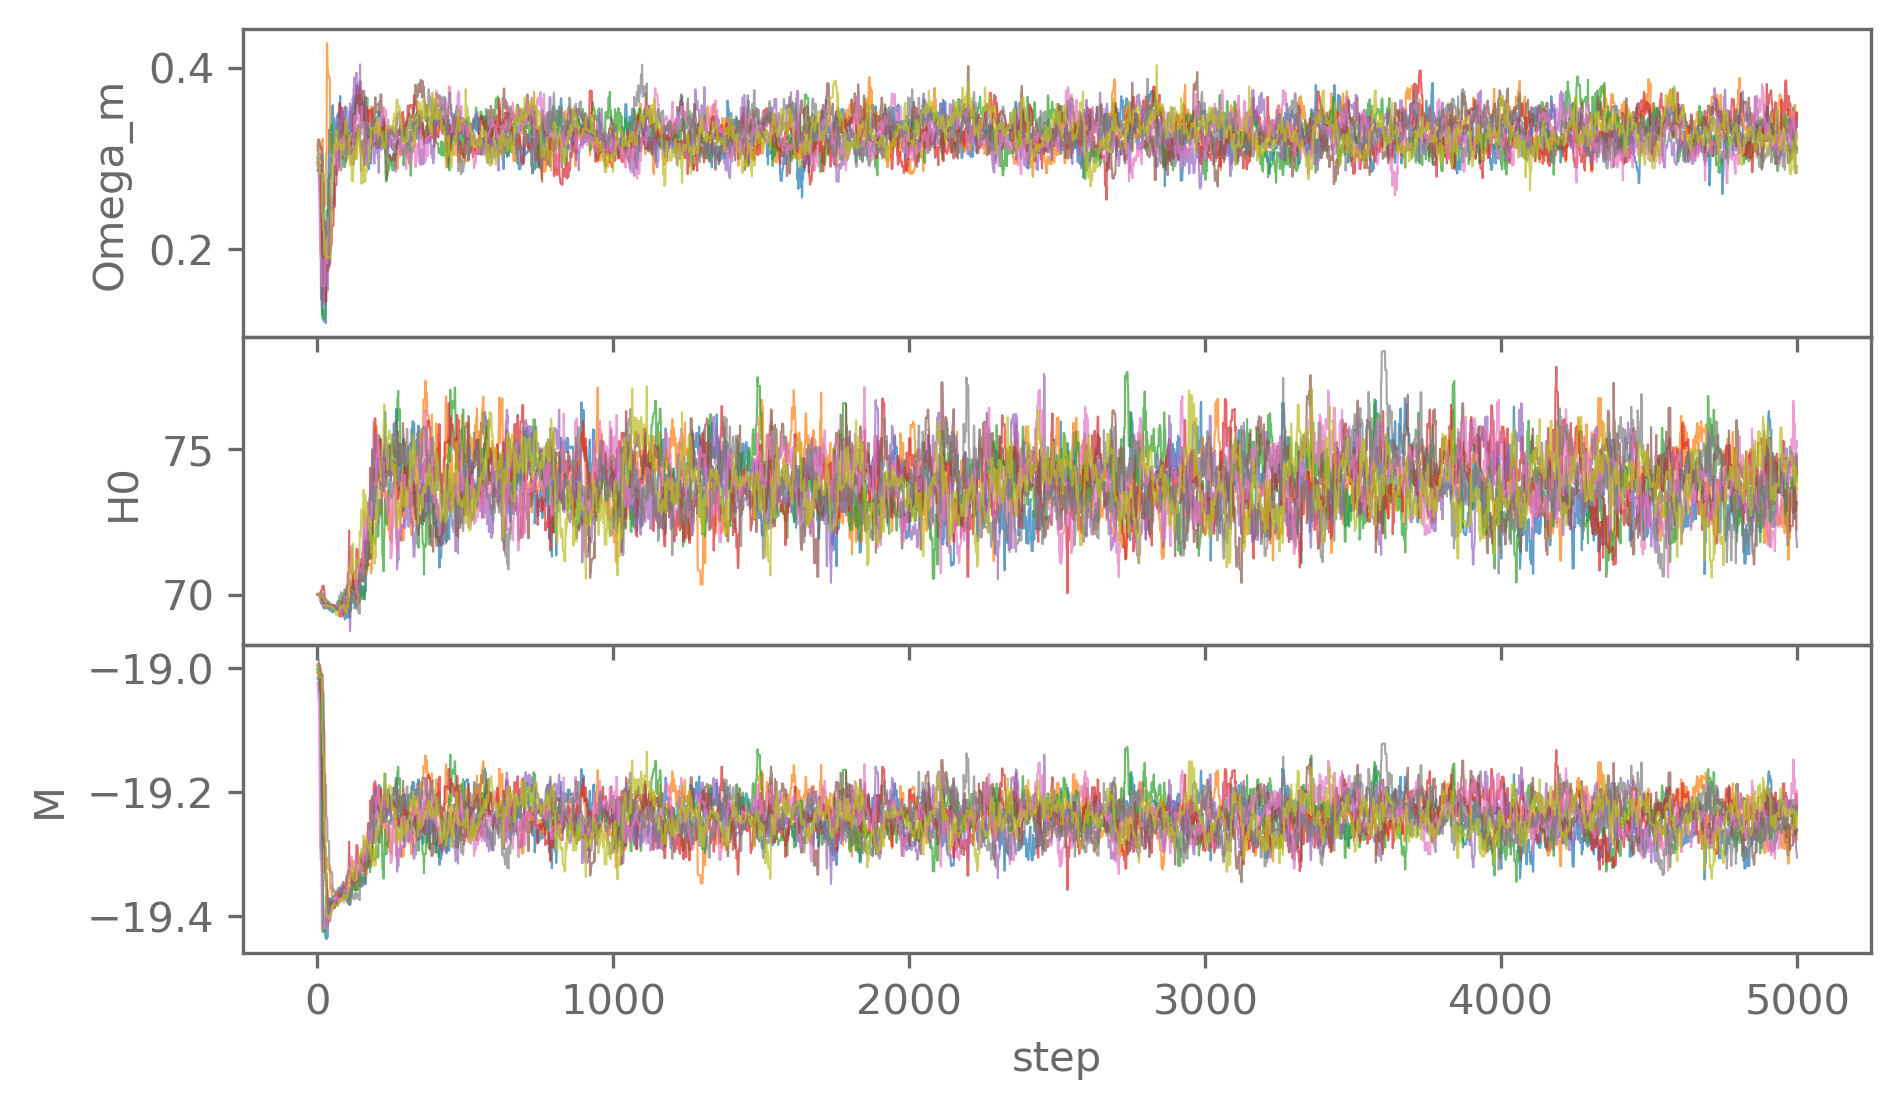

In [11]:
n_walker = 9
param_names = ["Omega_m", "H0", "M"]

# Plot the tracer of the chain, this time for all the walkers
fig, ax = plt.subplots(len(param_names), 1, sharex=True)
plt.subplots_adjust(hspace=0)

for i, name in enumerate(param_names):
    for j in range(n_walker):
        ax[i].plot(chain_per_walker[:, j, i], lw=0.5, alpha=0.7, color=f"C{j}")
    ax[i].set_ylabel(name)

ax[-1].set_xlabel("step");

The first couple hundred steps are clearly affected by burn-in.

Otherwise the chain looks good:
- The mean and variance do not vary with time, indicating that the distribution is stationary.
- The different walkers all explore the distribution and do not get stuck in a subspace.

## Auto-correlation/effective number of samples

A more quantitative check is the (integrated) auto-correlation time $\tau$, which tells us how long the chain takes to "forget" a previous position.

The `emcee` documentation has an excellent write-up on this: https://emcee.readthedocs.io/en/stable/tutorials/autocorr/


In short, if the chain has $n$ samples in it, the number of effective independent samples is $n_\mathrm{eff}\approx \frac{n}{\tau}$.


One thing to keep in mind is that for $n \lesssim 50\tau$, the estimate for $\tau$ will be unreliable.

In [29]:
# If the chain is an array (for example from a different MCMC algorithm)
tau = emcee.autocorr.integrated_time(chain_per_walker)

# If the algorithm does use walkers, set the has_walkers=False argument
# tau = emcee.autocorr.integrated_time(chain_per_walker[:, 0], has_walkers=False)

# Or directly from emcee:
# tau = sampler.get_autocorr_time()

print("Integrated auto-correlation time")
for name, iat in zip(param_names, tau):
    print(f"{name}: {iat:.1f}")

Integrated auto-correlation time
Omega_m: 46.0
H0: 79.8
M: 48.8


This indicates that the chain needs 50-80 steps to produce a new independent sample. 


To get rid of the burn-in phase, it is good to discard a few (5-10) auto-correlation times. 

This agrees with what we could estimate from the trace plots earlier.

Since many of the samples in the chain are correlated, we can thin down the chain by a factor of $\approx\tau$.

In [37]:
max_autocorr = max(tau)
burn_in = int(5*max_autocorr)
thin = int(max_autocorr/2)

chain = chain_per_walker[burn_in::thin].reshape(-1, n_param)
# Directly from an emcee sampler:
# chain = sampler.get_chain(discard=burn_in, thin=thin, flat=True)

# Interpreting posteriors

We have evaluated and sampled a few posteriors so far. As Bayesians, that is the end-goal, since the full posterior distribution is what we care about.

In practice, we need to summarise the posterior in a form that allows it to be represented on a sheet of paper.



- Mode of the posterior 
    - pro: summary of the full $n$-dimensional joint posterior
    - con: point estimate, uncertainty is hard to define in practice


- Credible intervals
    - pro: intuitive interpretation, can be put in a table
    - con: only applies to 1D (marginal) distributions, can suffer from projection effects



- Corner plots
    - pro: more information than credible intervals due to showing 2D marginals as well
    - con: still only marginals, can suffer from projection effects

#### Credible interval or region

A credible region for a probability distribution $p(x)$ is a set $\Omega(\alpha)$ such that the probability enclosed within that region is $1-\alpha$:
$$
    \int_{\Omega(\alpha)} p(x)\dd x = 1 - \alpha\,.
$$

There are infinitely many ways to define such regions but two common ones are 
- equal-tail intervals
- highest posterior density intervals

The equal-tail interval $(x_\mathrm{L}, x_\mathrm{R})$ is defined by requiring the tails of the distribution to each contain $\frac{\alpha}{2}$ of the total probability. 
$$
    \mathrm{CDF}(x_\mathrm{L}) = \frac{\alpha}{2}, \quad 1-\mathrm{CDF}(x_\mathrm{R}) = 1-\frac{\alpha}{2}
$$



The equal-tail interval is centred on the median of $p(x)$. The equal-tail interval has the advantage that it is easy to compute, for example from samples from a posterior.

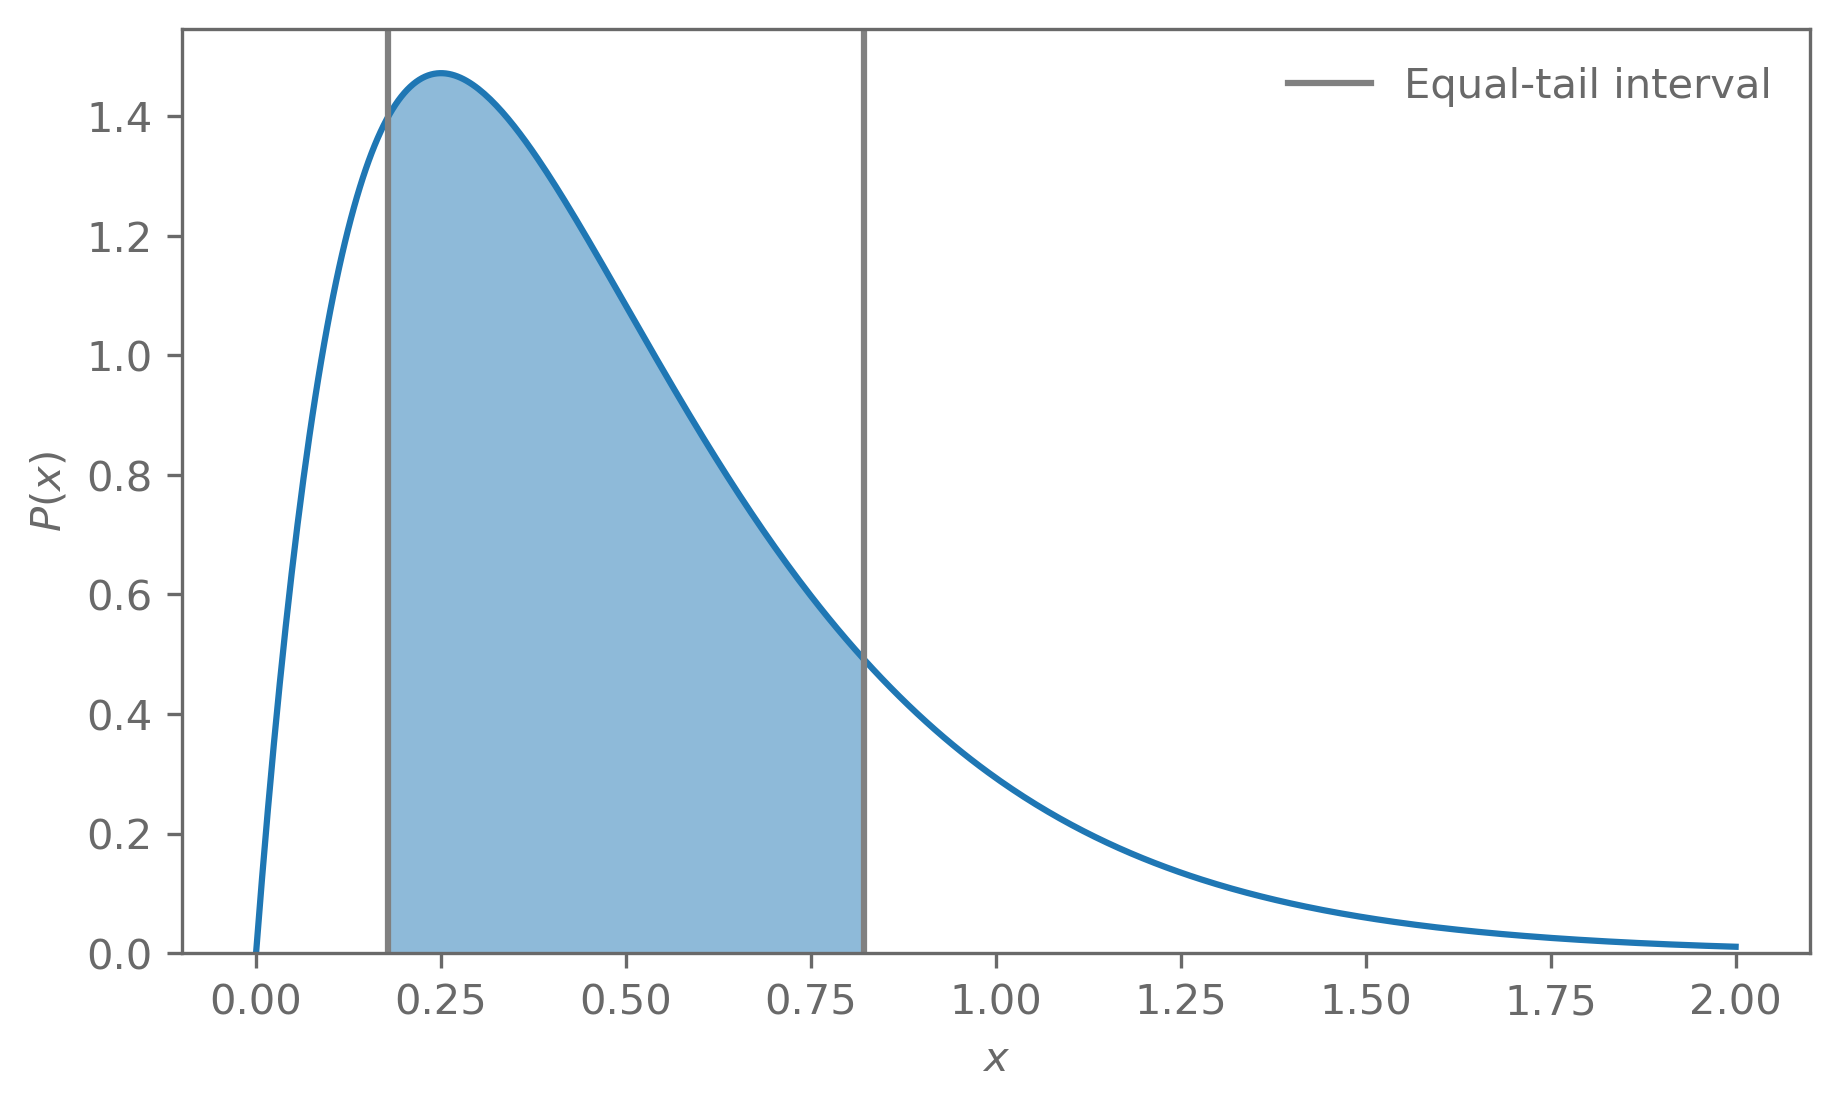

In [3]:
distr = scipy.stats.gamma(a=2, scale=1/4)

alpha = 1-0.68

x = np.linspace(0, 2, 500)

ci = distr.ppf(alpha/2), distr.ppf(1 - alpha/2)

plt.plot(x, distr.pdf(x))
x_ci = np.linspace(ci[0], ci[1], 100)
plt.fill_between(x_ci, 0, distr.pdf(x_ci), alpha=0.5)

plt.axvline(x=ci[0], c="grey", label="Equal-tail interval")
plt.axvline(x=ci[1], c="grey")

plt.ylim(bottom=0)

plt.xlabel("$x$")
plt.ylabel("$P(x)$")

_ = plt.legend()

The highest-density interval (or region) is defined as the region for which $p(x)$ is above a threshold $c_\alpha$, such that
$$
    \int_{\Omega(\alpha)} p(x)\dd x = 1 - \alpha\,,
$$
where
$$
    \Omega(\alpha) = \{x| p(x) > c_\alpha\}\,.
$$



The highest-density regions are the smallest possible credible region that can be defined. It is centred on the mode of $p(x)$.

The downside is that it is more complicated to compute (even in 1D). 

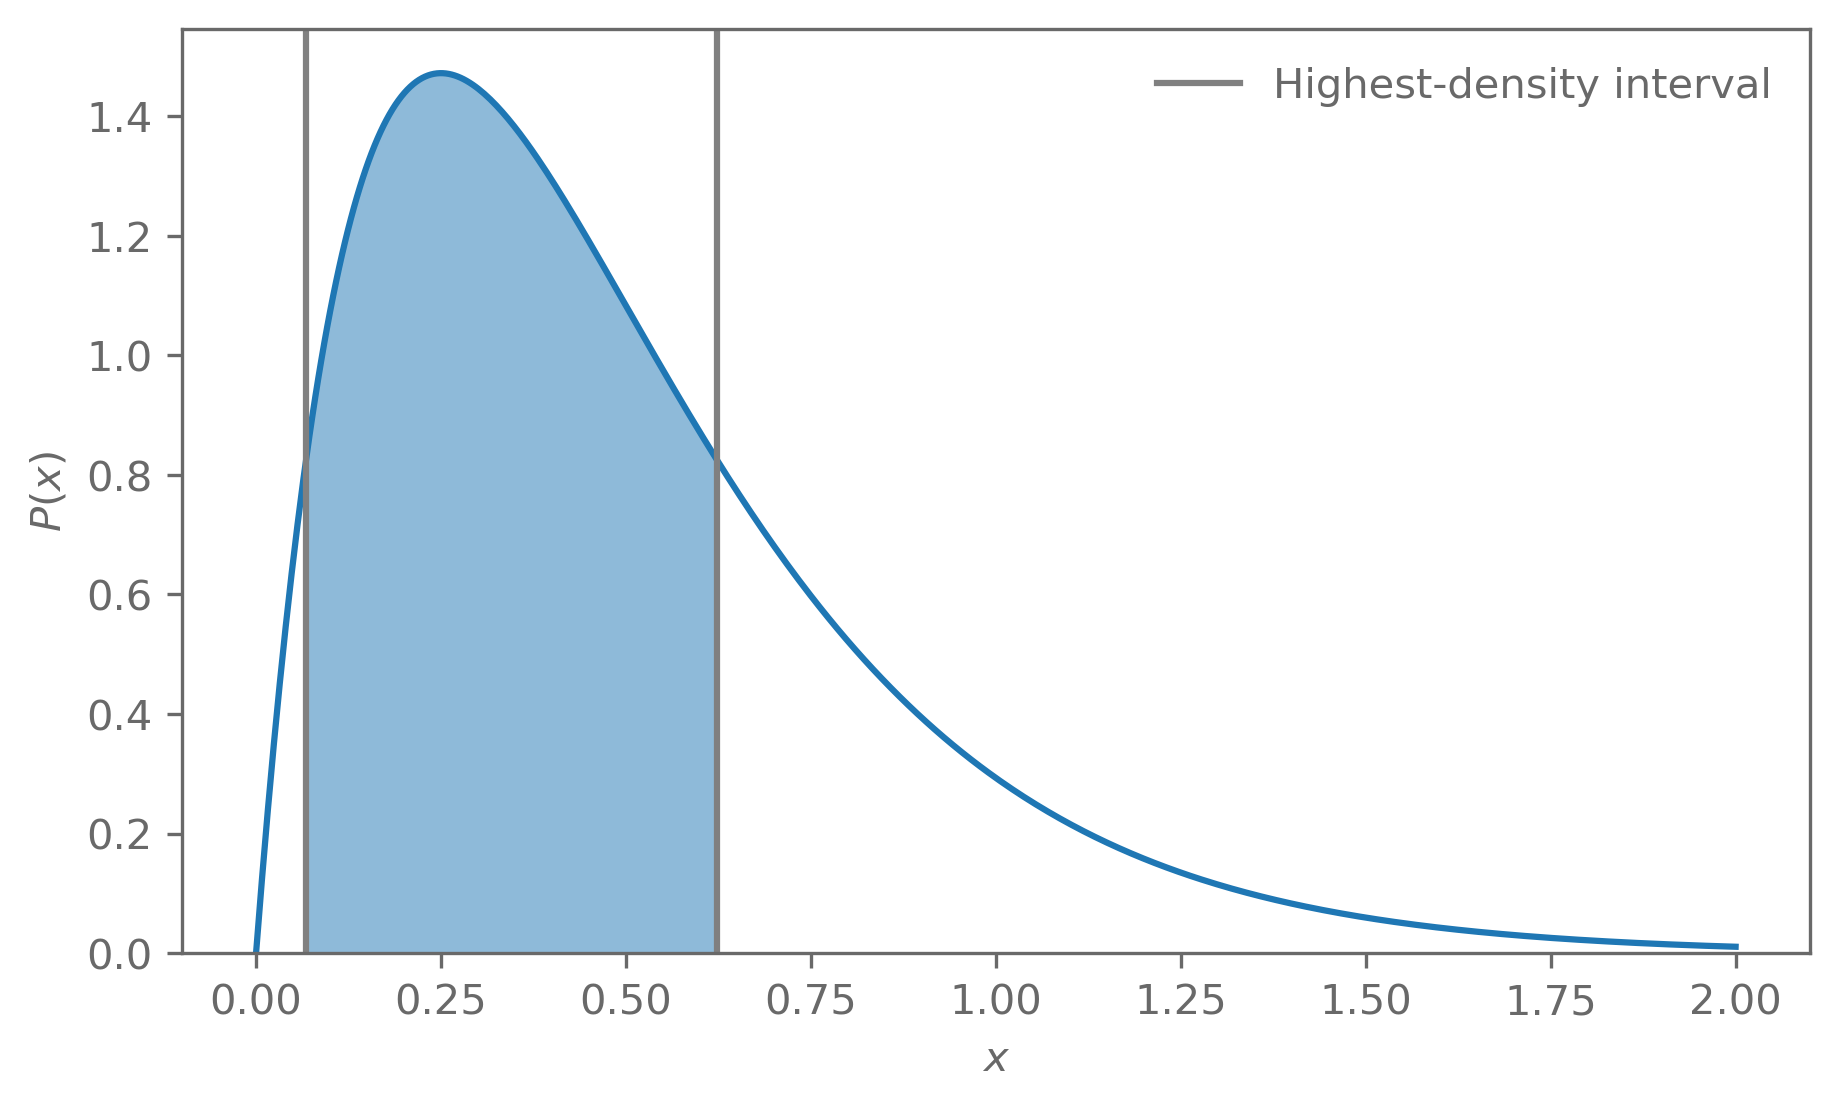

In [4]:
def find_ci(alpha, pdf_fn, mode, support):
    def c_to_alpha(c):
        ci_L = scipy.optimize.root_scalar(
            f=lambda x: c-pdf_fn(x),
            bracket=(support[0], mode)).root
        ci_R = scipy.optimize.root_scalar(
            f=lambda x: c-pdf_fn(x),
            bracket=(mode, support[1])).root
        alpha = distr.cdf(ci_R) - distr.cdf(ci_L)
        return alpha, (ci_L, ci_R)
    
    min_c = max(pdf_fn(support[0]), pdf_fn(support[1]))

    c = scipy.optimize.root_scalar(
        f=lambda c: c_to_alpha(c)[0] - alpha,
        bracket=(min_c, pdf_fn(mode))).root
    
    return c_to_alpha(c)[1]

mode = scipy.optimize.minimize(lambda x: -distr.logpdf(x), x0=1.0).x.squeeze()

ci = find_ci(alpha=0.68, pdf_fn=distr.pdf, mode=mode, support=(0, 2))

plt.plot(x, distr.pdf(x))
x_ci = np.linspace(ci[0], ci[1], 100)
plt.fill_between(x_ci, 0, distr.pdf(x_ci), alpha=0.5)

plt.axvline(x=ci[0], c="grey", label="Highest-density interval")
plt.axvline(x=ci[1], c="grey")

plt.ylim(bottom=0)

plt.xlabel("$x$")
plt.ylabel("$P(x)$")

_ = plt.legend()


<img style="display: block; 
    margin-left: auto;
    margin-right: auto;
    width: 70%;"
    src="../assets/hpd_animation.gif" alt="HPD"/>

#### Projection effects

Once we have more than 2 dimensions in our posterior, we can only visualise marginal distributions of it (unless you use a fancy 3D plotting library).

These marginal distributions can behave in unintuitive ways when the posterior is not symmetric and Gaussian.

In [5]:
def model(x, a, b, c, d):
    x0=0.5
    return a + b * x * ((1+x)/(1+x0))**c * ((1+x**2)/(1+x0**2))**d

In [6]:
a_prior = tfd.Uniform(low=-10, high=10)
b_prior = tfd.Uniform(low=-10, high=10)
c_prior = tfd.Uniform(low=-1000, high=1000)
d_prior = tfd.Uniform(low=-1000, high=1000)


# Generate synthetic data
np.random.seed(42)
x = jnp.linspace(0, 1, 10)
true_params = [2, 0.1, 0, 0]
y = model(x, *true_params)
y_err = 0.05 * jnp.ones_like(y)


def create_likelihood_distribution(model, y_err):
    def distr(params, x):
        mu = model(x, *params)
        return tfd.MultivariateNormalDiag(loc=mu, scale_diag=y_err)

    return distr


def log_likelihood(params):
    return create_likelihood_distribution(model=model, y_err=y_err)(params, x).log_prob(y)

def log_prior(params):
    return a_prior.log_prob(params[0]) + b_prior.log_prob(params[1]) + c_prior.log_prob(params[2]) + d_prior.log_prob(params[3])

# Define the log posterior
def log_posterior(params):
    return log_likelihood(params) + log_prior(params)


In [7]:
params_initial = jnp.array([1.0, 1.0, 1.0, 1.0])
param_names = ["a", "b", "c", "d"]

solver = jaxopt.ScipyMinimize(fun=jit(lambda x: -log_posterior(x)), method="L-BFGS-B")
solution = solver.run(params_initial)
MAP_params = solution.params
cov = jnp.linalg.inv(-hessian(log_posterior)(MAP_params))

print("Model 1")
for name, p, p_std, p_true in zip(param_names, MAP_params, np.sqrt(np.diag(cov)), true_params):
    print(f"{name} = {p:.2f} ± {p_std:.2f} (truth: {p_true:.2f})")


Model 1
a = 2.00 ± 0.05 (truth: 2.00)
b = 0.10 ± 0.11 (truth: 0.10)
c = 0.28 ± 18.64 (truth: 0.00)
d = -0.17 ± 11.37 (truth: 0.00)


In [8]:

# Set up the initial parameters for the MCMC
initial_params = np.array([1.0, 1.0, 1.0, 1.0])
ndim = len(initial_params)
nwalkers = 32
nsteps = 10000

# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, jit(vmap(log_posterior)), vectorize=True)

# Initialize the walkers
p0 = np.random.normal(initial_params, scale=0.1, size=(nwalkers, ndim))

# Run the MCMC
sampler.run_mcmc(p0, nsteps, progress=True)

max_autocorr = max(sampler.get_autocorr_time())
# Extract the samples
samples = sampler.get_chain(discard=int(5*max_autocorr), thin=int(max_autocorr/2), flat=True)

100%|██████████| 10000/10000 [00:03<00:00, 2667.46it/s]


In [9]:
getdist_samples = getdist.MCSamples(
    samples=samples,
    names=param_names,
    label="Model 1",
    ranges={"c": (-1000, 1000), "d": (-1000, 1000)}
)

Removed no burn in


In [10]:
g = getdist.plots.get_single_plotter()

<Figure size 1800x1350 with 0 Axes>

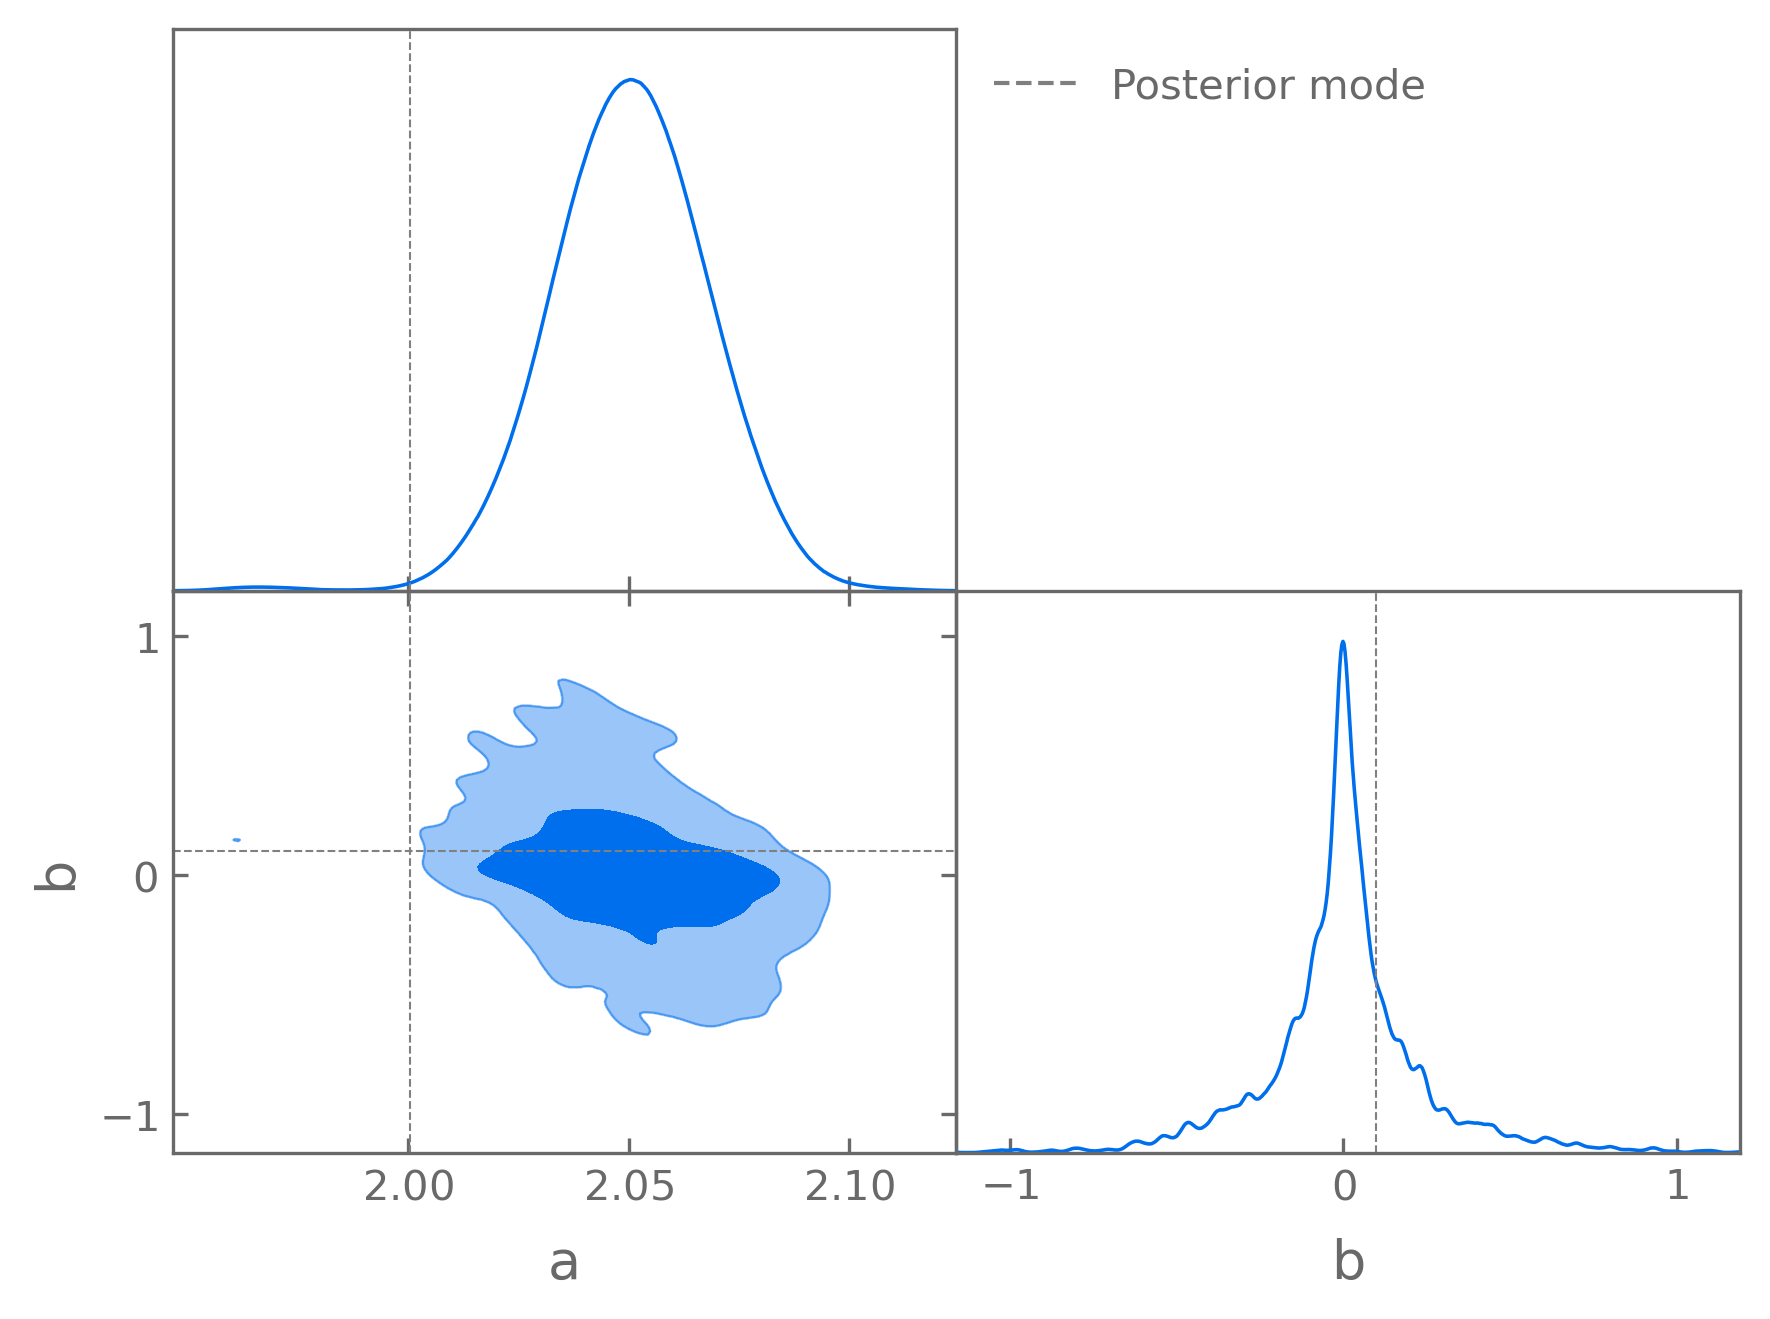

In [11]:
g.triangle_plot([getdist_samples],
                params=["a", "b"],
                filled=True,
                markers={k: v for k, v in zip(param_names, MAP_params)})

g.subplots[0,0].plot([],[], **{"lw" : 1.0, "ls" : "--", "c" : "k", "alpha" : 0.5}, label="Posterior mode")
g.subplots[0,0].legend(frameon=False, loc=2, bbox_to_anchor=(1,1));

In [12]:
g = getdist.plots.get_single_plotter()

<Figure size 1800x1350 with 0 Axes>

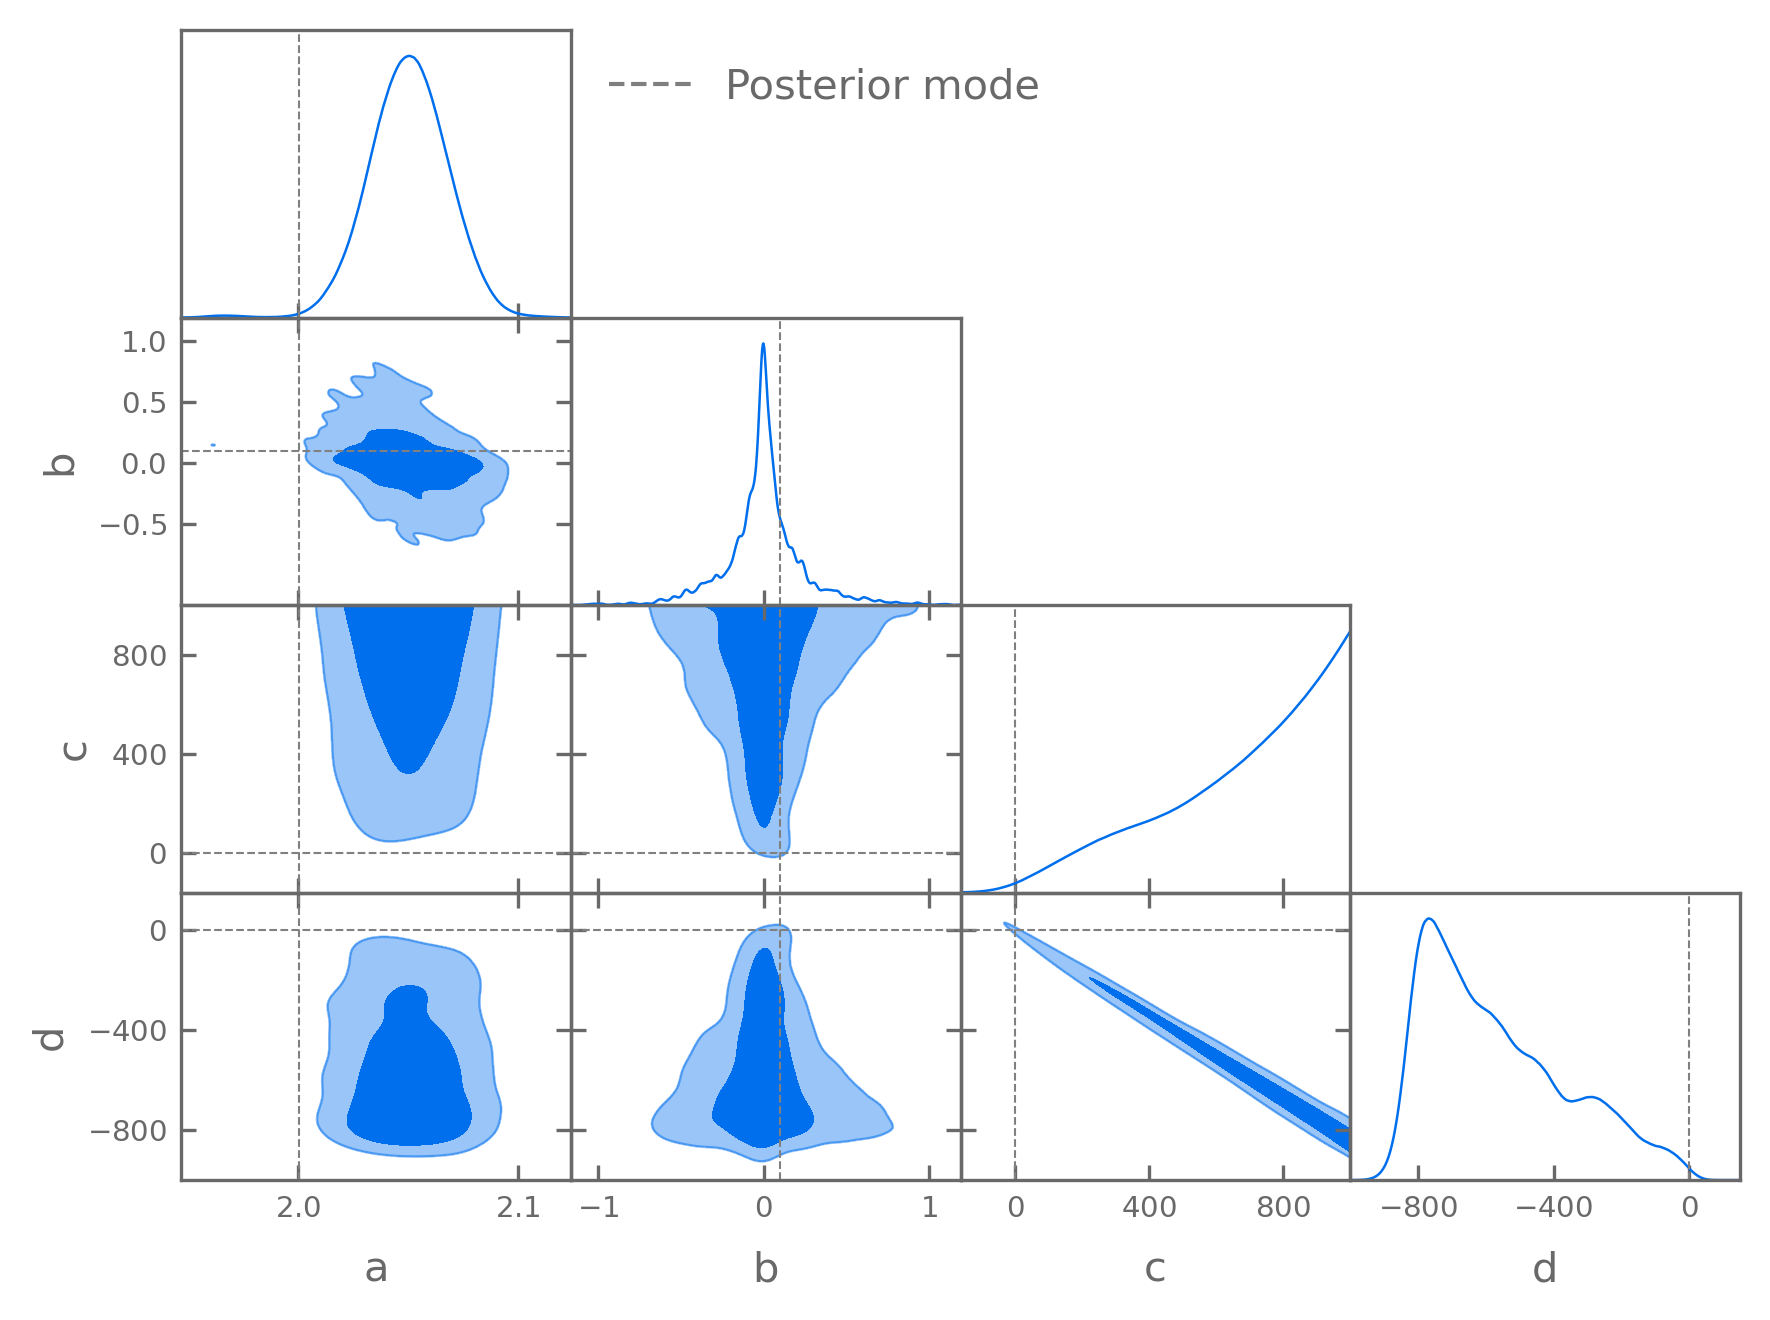

In [13]:
fig = g.triangle_plot([getdist_samples], filled=True,
                 markers={k: v for k, v in zip(param_names, MAP_params)})
g.subplots[0,0].plot([],[], **{"lw" : 1.0, "ls" : "--", "c" : "k", "alpha" : 0.5}, label="Posterior mode")
g.subplots[0,0].legend(frameon=False, loc=2, bbox_to_anchor=(1,1));

The model here is a Gaussian likelihood with mean
$$
    \mu = a + bx  \left(\frac{1+x}{1 + x_0}\right)^c \left(\frac{1+x^2}{1 + x_0^2}\right)^d\,,
$$
for parameters $a$, $b$, $c$, $d$, with $x_0=0.5$.

When $b\approx 0$, the terms involving $c$ and $d$ do not contribute to the model anymore and $c$ and $d$ are not constrained.

Depending on how the prior is chosen, this can lead to large volumes of posterior space where $b\approx 0$.

When projecting the posterior into marginal distributions, this leads to marginals that are not centred on the mode of the joint posterior.

This can be seen with very skewed distributions even in 2 dimensions:

In [14]:
def log_p(p):
    x, y = p
    if y < 0 or x < 0 or y > x or y < x/2:
        return -np.inf
    
    return -(x+y)**2

theta_fid = (0.5, 0.5)
nwalkers = 32
ndim = len(theta_fid)

n_sample = 12000
burn_in = 2000

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_p)

sampler.run_mcmc(np.random.normal(loc=0, scale=0.1, size=(nwalkers,ndim))+theta_fid, n_sample, progress=True)
max_autocorr = max(sampler.get_autocorr_time())

samples = getdist.MCSamples(name_tag="Full",
                            samples=sampler.get_chain(flat=True, discard=int(5*max_autocorr), thin=int(max_autocorr/2)),
                            names=["theta0", "theta1"], labels=["x", "y"],
                            ranges={"theta0" : [0,4], "theta1" : [0,4],}
                                   )

100%|██████████| 12000/12000 [00:02<00:00, 4749.10it/s]

Removed no burn in


In [15]:
MAP = [0,0]

samples.smooth_scale_1D = 0.2
samples.smooth_scale_2D = 0.2

g = getdist.plots.get_single_plotter()
g.settings.legend_frame = False


<Figure size 1800x1350 with 0 Axes>

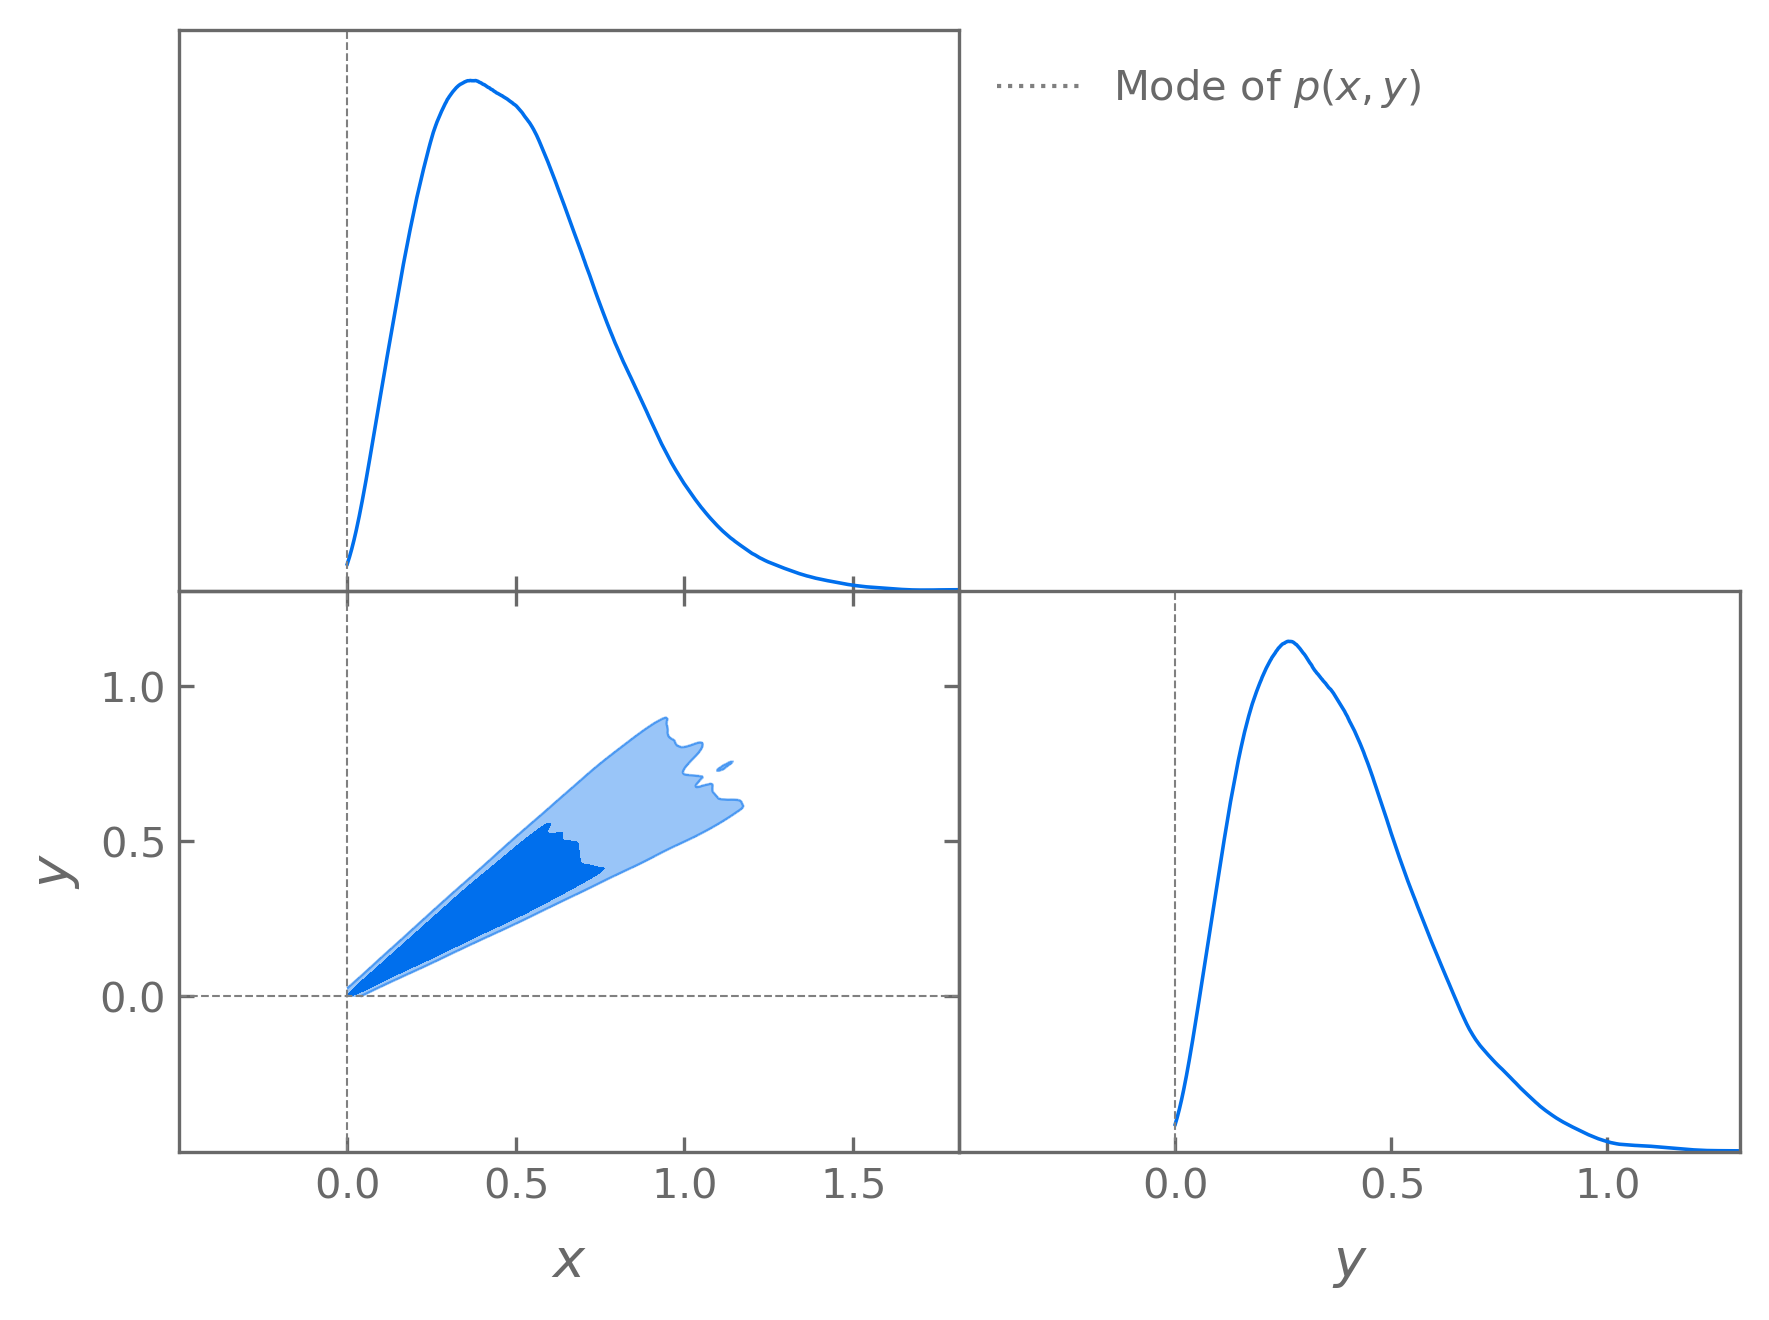

In [16]:

g.triangle_plot([samples],
                filled_compare=True,
                params=["theta0", "theta1"],
                markers={"theta0" : MAP[0], 
                         "theta1" : MAP[1],
                         },
               )

g.subplots[0,0].set_xlim(left=-0.5)
g.subplots[1,1].set_xlim(left=-0.5)

g.subplots[0,0].plot([],[], **{"lw" : 1.0, "ls" : ":", "c" : "k", "alpha" : 0.5}, label="Mode of $p(x, y)$")
g.subplots[0,0].legend(frameon=False, loc=2, bbox_to_anchor=(1,1));

### Clicker

What causes volume or projection effects?
- The projection of high dimensions onto marginal distributions.
- Unconstrained regions in the parameter space due to degeneracy between parameters.
- The influence of the prior distribution on the effective number of parameters.
- Data rescaling on the posterior distribution.

## The Bayesian data analysis workflow

1. Model the data generating process probabilistically.
2. Condition the generative process on the observed data.
3. Check that the results fit the observed data and improve the model.
    - Compare different models.

## Model checking

A first step to check your model is to plot it against the data.

This can be plotting the best-fit model, but better are the posterior predictive distributions.

If there are obvious issues, such as outliers or misspecified errors, making some plots can already flag these problems.

Our eyes can be easily deceived though. For example, strongly correlated data can have _very_ unintuitive behaviour of the best-fitting model.

### Chi-square goodness-of-fit

If the data $\vec y$ are Gaussian distributed
$$
    \vec y\sim \Norm\left(\vec \mu(\vec\theta), \Sigma(\vec\theta)\right)
$$
then a traditional test of how well our model fits the data is the chi-square test. 



Let us assume we have a set $\vec\theta^*$ of "best" model parameters. For example the MAP or mean of the posterior.

If these are the true parameters that generated the data and the data are Gaussian distributed, then the quantity
$$
    \chi^2(\vec y, \vec\theta^*) = \left(\vec y - \vec\mu(\vec\theta^*)\right)^T\Sigma(\vec\theta^*)^{-1}\left(\vec y - \vec\mu(\vec\theta^*)\right)
$$
is distributed as $\chi^2_\nu$. 



With this we can calculate the probability that the $\chi^2$ statistic would take a higher value in imaginary repeated experiments than the one we have observed
$$
    \text{Probability to exceed (PTE) } \chi^2(\vec y, \vec\theta^*) = 1 - \mathrm{CDF}\left(\chi^2(\vec y, \vec\theta^*)\right)\ .
$$
If the PTE is small, it is unlikely that an experiment would see a $\chi^2$ statistic larger than what we observerd. This indicates that our model is a poor fit to the data.



The number of degrees of freedom is $\nu = n_\mathrm{data} - n_\mathrm{param}$, where $n_\mathrm{data}$ is the dimensionality of the data and $n_\mathrm{param}$ is the number of constrained parameters.


By fitting the model to the data, we reduce the scatter in the residuals $\vec y - \vec\mu(\theta)$, so the number of degrees of freedom is reduced from $n_\mathrm{data}$ by $n_\mathrm{param}$.

Finding $n_\mathrm{param}$ in a Bayesian context can be challenging because some parameters might be constrained by the prior, instead of by the likelihood. In this case, they do not reduce the degrees of freedom.

We use the data in `"data/linear_fits/data_2.txt"` has an example and fit both a linear and quadratic model to it.

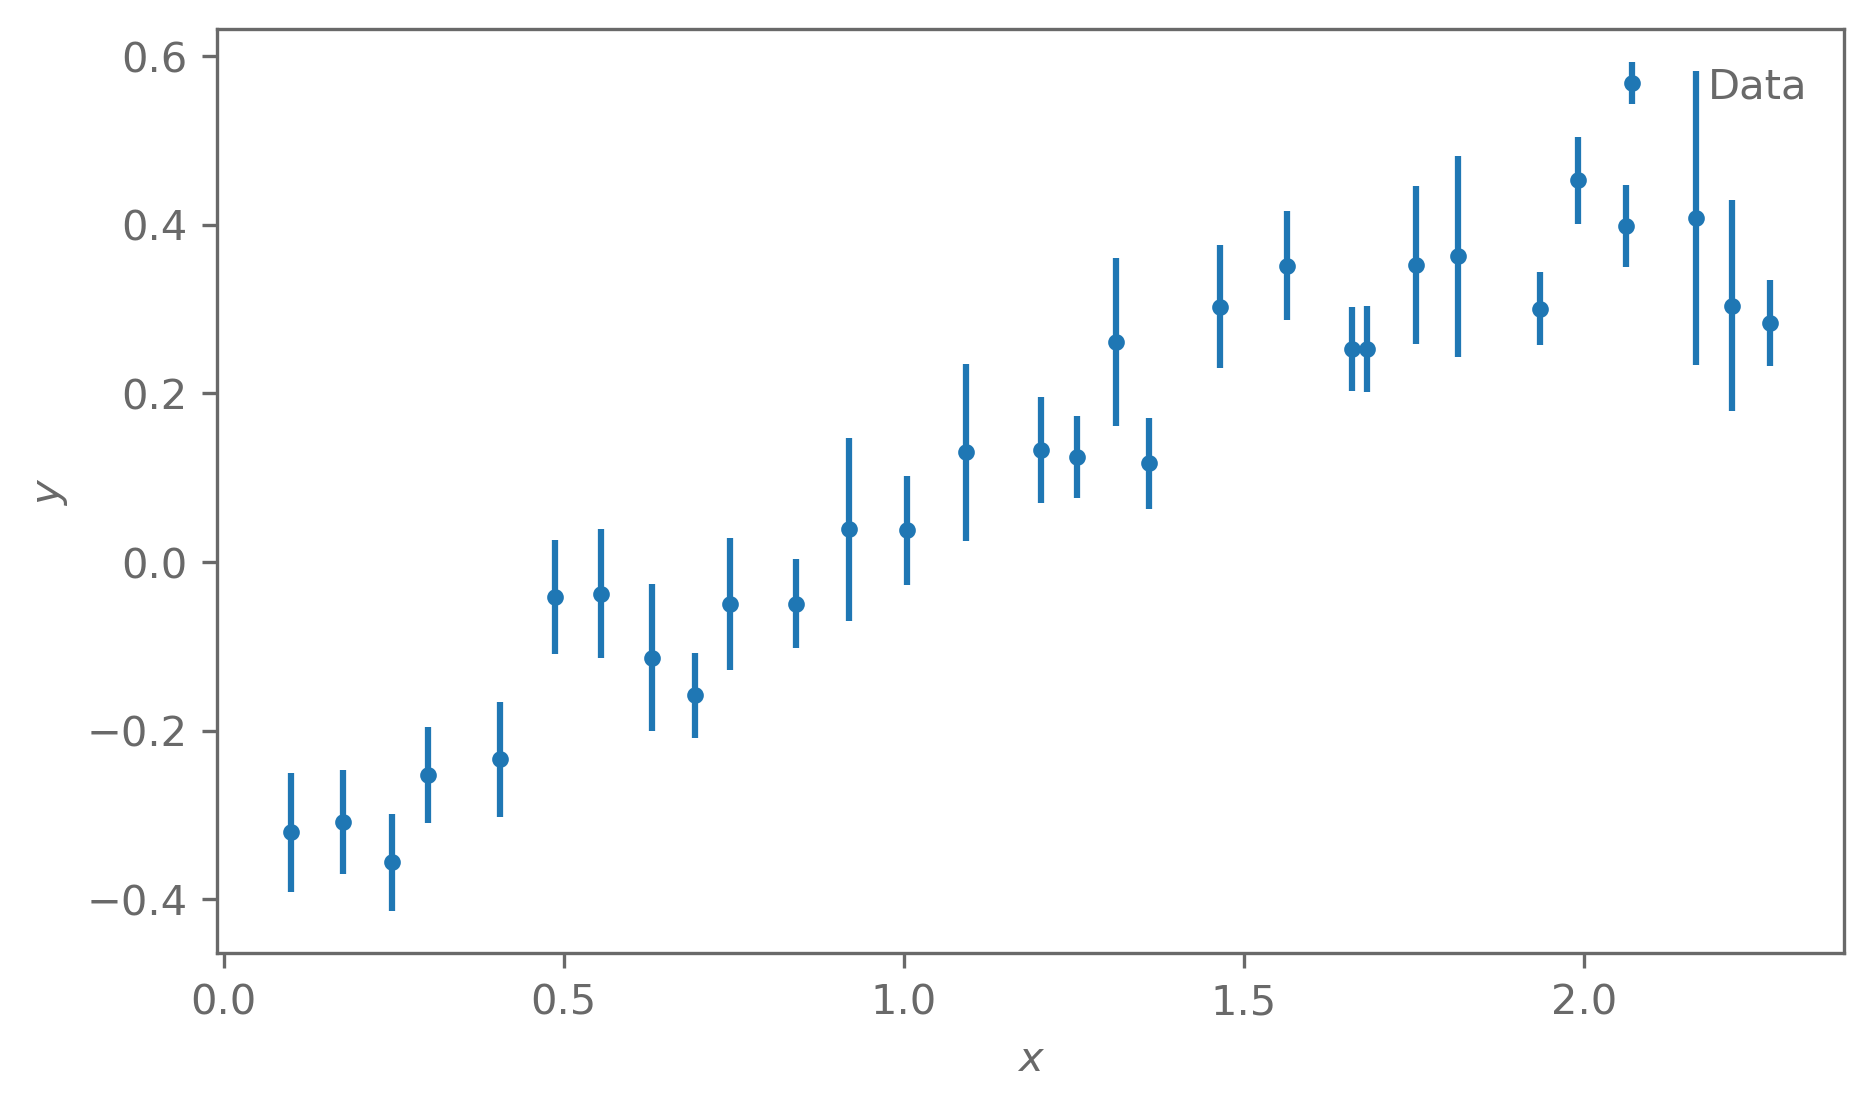

In [56]:
x, y, y_err = np.loadtxt("data/linear_fits/data_2.txt", unpack=True)
a_true, b_true, c_true,  = -0.15, 0.7, -0.45

plot_data(x, y, y_err);

In [57]:
def make_gaussian_likelihood_components(model, log_prior):
    """Create the log_likelihood, log_posterior, predict functions from a
    model and log_prior"""
    def log_likelihood(y, theta, x, sigma_y):
        prediction = model(theta, x)

        return (
            -0.5 * np.sum((y - prediction)**2/sigma_y**2)    # Exponent
            -0.5 * np.sum(np.log(2*np.pi*sigma_y**2))        # Normalisation
        )
    
    def log_posterior(theta, x, sigma_y, y):
        return log_likelihood(y, theta, x, sigma_y) + log_prior(theta)
    
    def predict(theta, x, sigma_y):
        mu = model(theta, x)
        return np.random.normal(loc=mu, scale=sigma_y)
    
    return log_likelihood, log_posterior, predict

In [58]:
def linear_model(theta, x):
    m, b = theta
    return m*x + b

def log_prior_linear_model(theta):
    m, b = theta
    # Unnormalised uniform prior m\simU(-2, 2), b \sim U(-3, 3)
    if -2 < m < 2 and -3 < b < 3:
        return 0
    else:
        return -np.inf

log_likelihood_lin, log_posterior_lin, predict_lin = \
    make_gaussian_likelihood_components(
        linear_model, log_prior_linear_model
    )

In [59]:
def quadratic_model(theta, x):
    a, b, c = theta
    return a*x**2 + b*x + c

def log_prior_quadratic_model(theta):
    a, b, c = theta
    # Unnormalised uniform prior m\simU(-2, 2), b \sim U(-3, 3)
    if -1 < a < 1 and -2 < b < 2 and -3 < c < 3:
        return 0
    else:
        return -np.inf

log_likelihood_quad, log_posterior_quad, predict_quad = \
    make_gaussian_likelihood_components(
        quadratic_model, log_prior_quadratic_model
    )

In [69]:
# From bayesian_stats_course_tools.analyse
# This function returns a dict with the following entries:
# - MAP: parameter values at the MAP
# - PPD: samples from the posterior predictive distribution
# - PPD_params: the parameter samples for the samples in of the PPD
# - TPD: samples from the TPD (samples of model predictions)
# - chain: MCMC chain of the parameters
results_linear = analyse_data(
    data=dict(x=x, y=y, y_err=y_err),
    log_posterior_fn=log_posterior_lin,
    model_fn=linear_model,
    predict_fn=predict_lin,
    param_names=["m", "b"],
    theta_init=[1, 0],
    plot=False
)

results_quadratic = analyse_data(
    data=dict(x=x, y=y, y_err=y_err),
    log_posterior_fn=log_posterior_quad,
    model_fn=quadratic_model,
    predict_fn=predict_quad,
    param_names=["a", "m", "b"],
    theta_init=[0.1, 1, 0],
    plot=False
)

MAP results
m_MAP = 0.34908377290541787
b_MAP = -0.33212704099855833


100%|██████████| 5000/5000 [00:01<00:00, 3970.07it/s]


Auto-correlation time of chain:
m = 16.3
b = 37.9
Posterior results (mean±std)
m = 0.35±0.017
b = -0.33±0.024
MAP results
a_MAP = -0.10547710642388063
m_MAP = 0.5990527808099008
b_MAP = -0.4340001193160153


100%|██████████| 5000/5000 [00:01<00:00, 3810.05it/s]

Auto-correlation time of chain:
a = 65.4
m = 56.2
b = 58.9
Posterior results (mean±std)
a = -0.11±0.031
m = 0.6±0.076
b = -0.43±0.038


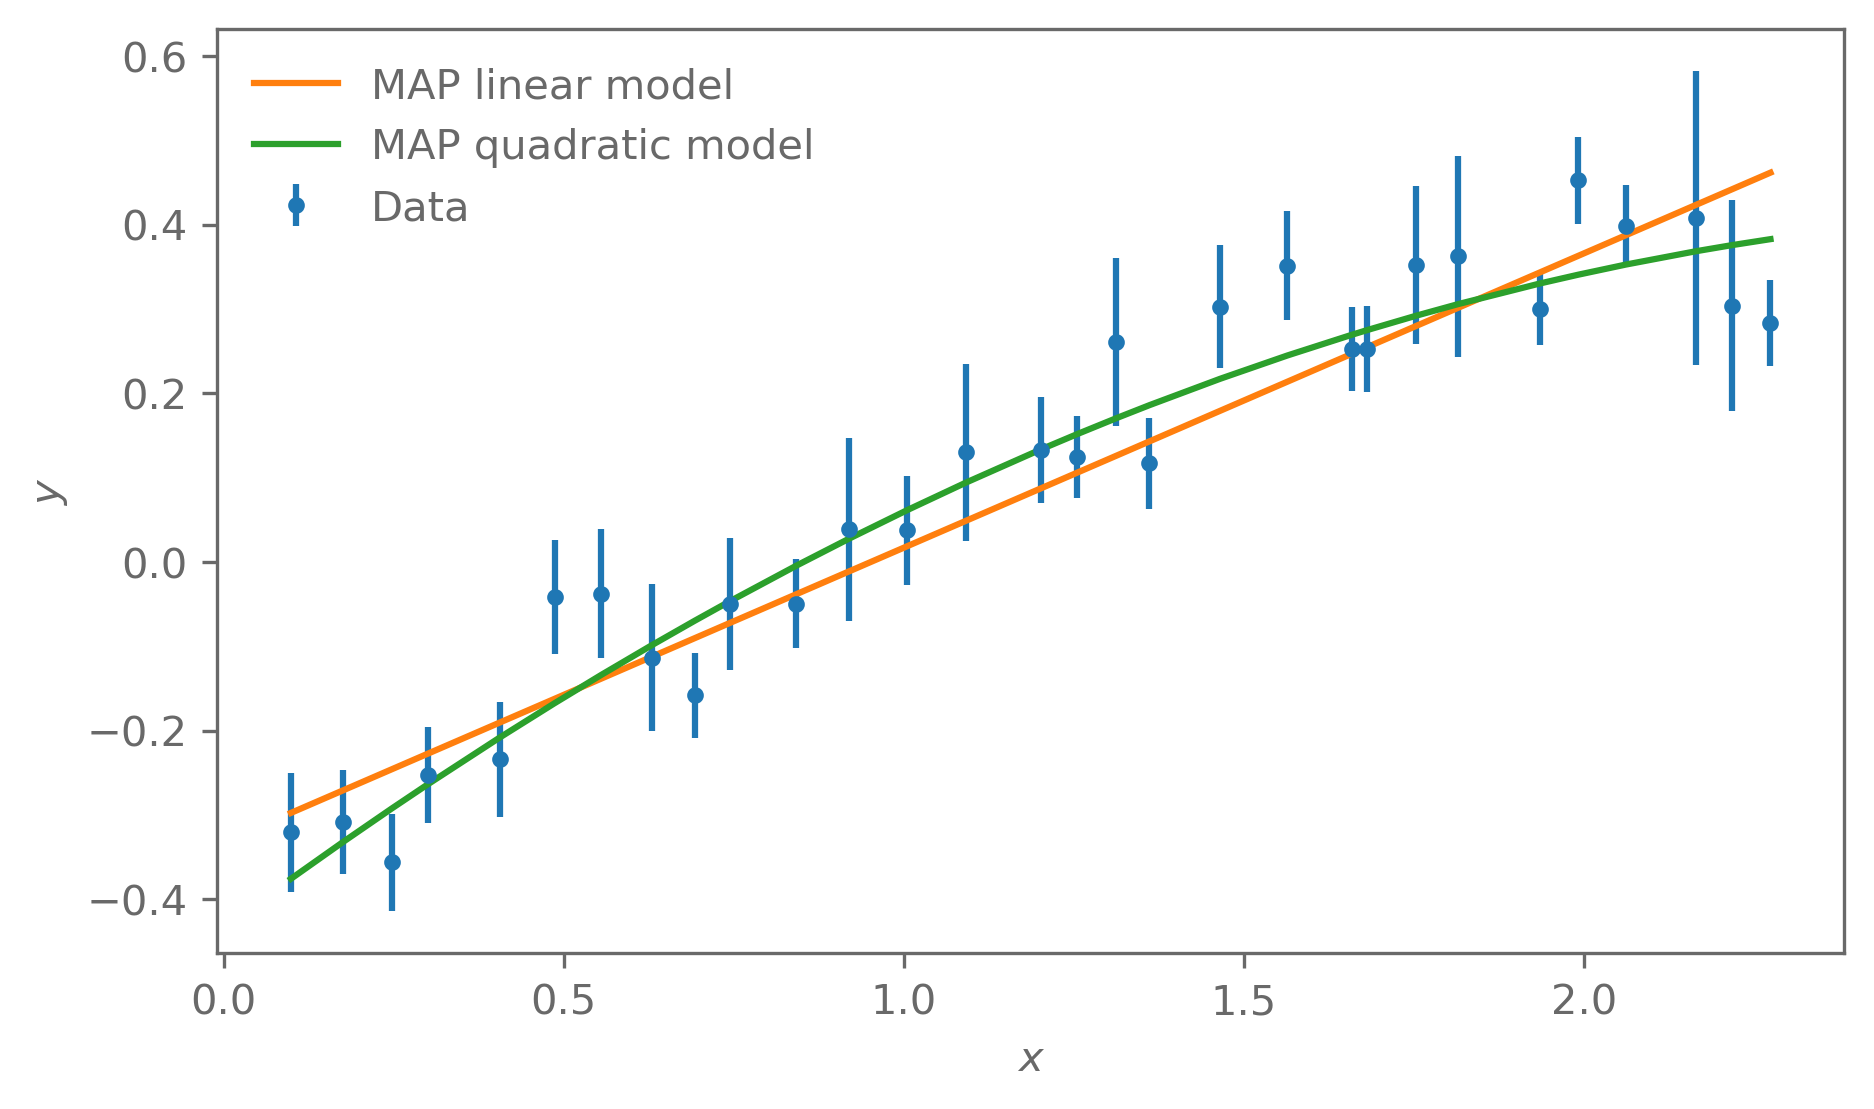

In [70]:
plot_data(
    x, y, y_err,
    models=[
        dict(x=x, y=linear_model(results_linear["MAP"], x), style=dict(label="MAP linear model")),
        dict(x=x, y=quadratic_model(results_quadratic["MAP"], x), style=dict(label="MAP quadratic model"))
    ]
);

Implement the $\chi^2$ statistic:

In [71]:
def chi_squared(y, sigma_y, mu):
    return np.sum((y - mu)**2/sigma_y**2)

chi_squared_linear = chi_squared(
    y, y_err,
    mu=linear_model(results_linear["MAP"], x)
)
chi_squared_quadratic = chi_squared(
    y, y_err,
    mu=quadratic_model(results_quadratic["MAP"], x)
)

In [63]:
n_data = len(y)
n_param_lin = 2
n_param_quad = 3

PTE_lin = scipy.stats.chi2(df=n_data - n_param_lin).sf(chi_squared_linear)
PTE_quad = scipy.stats.chi2(df=n_data - n_param_quad).sf(chi_squared_quadratic)

print(f"Linear: χ²={chi_squared_linear:.1f}, "
      f"ndof={n_data}-{n_param_lin}, PTE={PTE_lin:.3f}")

print(f"Quadratic: χ²={chi_squared_quadratic:.1f}, "
      f"ndof={n_data}-{n_param_quad}, PTE={PTE_quad:.3f}")

Linear: χ²=40.8, ndof=30-2, PTE=0.056
Quadratic: χ²=29.3, ndof=30-3, PTE=0.347


The quadtratic model fits much better to the data. Note that for the linear model, the probability of getting data that has an even higher $\chi^2$ than we observed is quite low, indicating that the linear model is a poor fit. 

## Posterior predictive checks

For more details, see chapter 6 in Bayesian Data Analysis

The chi-squared test has some downsides:
- It assumes the data are Gaussian distributed.
- It depends on the effective number of constrained parameters, which can be challenging to define.
- It uses a point estimate for the parameters $\vec\theta^*$ for which to calculate the goodness-of-fit. As Bayesians, we want to avoid point estimates and instead account for the full uncertainty in the posterior.


We use the posterior predictive distribution (PPD) to assess how well our model fits the data.

We define a test statistic $T(y, \theta)$ of the data and the parameters.
For example, we could choose the $\chi^2$ statistic
$$
    T(\vec y, \vec\theta) = \left(\vec y - \vec\mu(\vec\theta)\right)^T\Sigma(\vec\theta)^{-1}\left(\vec y - \vec\mu(\vec\theta)\right) \ .
$$
The $\chi^2$ statistic is often convenient but other choice for $T(y, \theta)$ are possible too.




We then sample replicates $\vec y^\mathrm{rep}$ of the data from the PPD $p(\vec y^\mathrm{rep}|\vec y)$. Remember,
$$
    p(\vec y^\mathrm{rep}|\vec y) = \int p(\vec y^\mathrm{rep}, \vec \theta | \vec y)\dd \theta = \int p(\vec y^\mathrm{rep} |\vec  \theta)p(\vec \theta|\vec y)\dd \theta\,.
$$



Then compute the probability
$$
    \Pr\left(T(\vec y^\mathrm{rep}, \vec\theta) \geq T(\vec y, \vec\theta)|\vec y\right)\ .
$$

In practice:
1. Sample $S$ samples $\vec\theta_i$ from the posterior $p(\vec\theta|\vec y)$
2. Sample one $\vec y^\mathrm{rep}_i$ from the likelihood $p(\vec y^\mathrm{rep}|\vec\theta_i)$ for each $\theta_i$
3. Count the fraction of samples where $T(\vec y^\mathrm{rep}_i, \vec\theta_i) \geq T(\vec y, \vec\theta_i)$

In [64]:
def test_statistic(y, theta, x, sigma_y, model):
    mu = model(theta, x)
    t = chi_squared(y, sigma_y, mu)
    return t

def ppd_model_check(test_statistic, y, ppd, ppd_params):
    t_data = []
    t_rep = []
    for y_rep, theta in zip(ppd, ppd_params):
        t_data.append(test_statistic(y, theta))
        t_rep.append(test_statistic(y_rep, theta))

    t_data = np.array(t_data)
    t_rep = np.array(t_rep)

    pte = (t_rep >= t_data).sum()/len(t_data)
    return pte, t_rep, t_data


In [65]:
PPD_PTE_lin, t_rep_lin, t_data_lin = ppd_model_check(
    test_statistic=lambda y, theta: test_statistic(
        y, theta, x, y_err, linear_model),
    y=y,
    ppd=results_linear["PPD"],
    ppd_params=results_linear["PPD_params"]
)

PPD_PTE_quad, t_rep_quad, t_data_quad = ppd_model_check(
    test_statistic=lambda y, theta: test_statistic(
        y, theta, x, y_err, quadratic_model),
    y=y,
    ppd=results_quadratic["PPD"],
    ppd_params=results_quadratic["PPD_params"]
)

print(f"Linear: PPD PTE={PPD_PTE_lin:.3f}")
print(f"Quadratic: PPD PTE={PPD_PTE_quad:.3f}")

Linear: PPD PTE=0.064
Quadratic: PPD PTE=0.372


We get quite similar results to the $\chi^2$ test just from samples from the posterior, without further assumptions or point estimates.

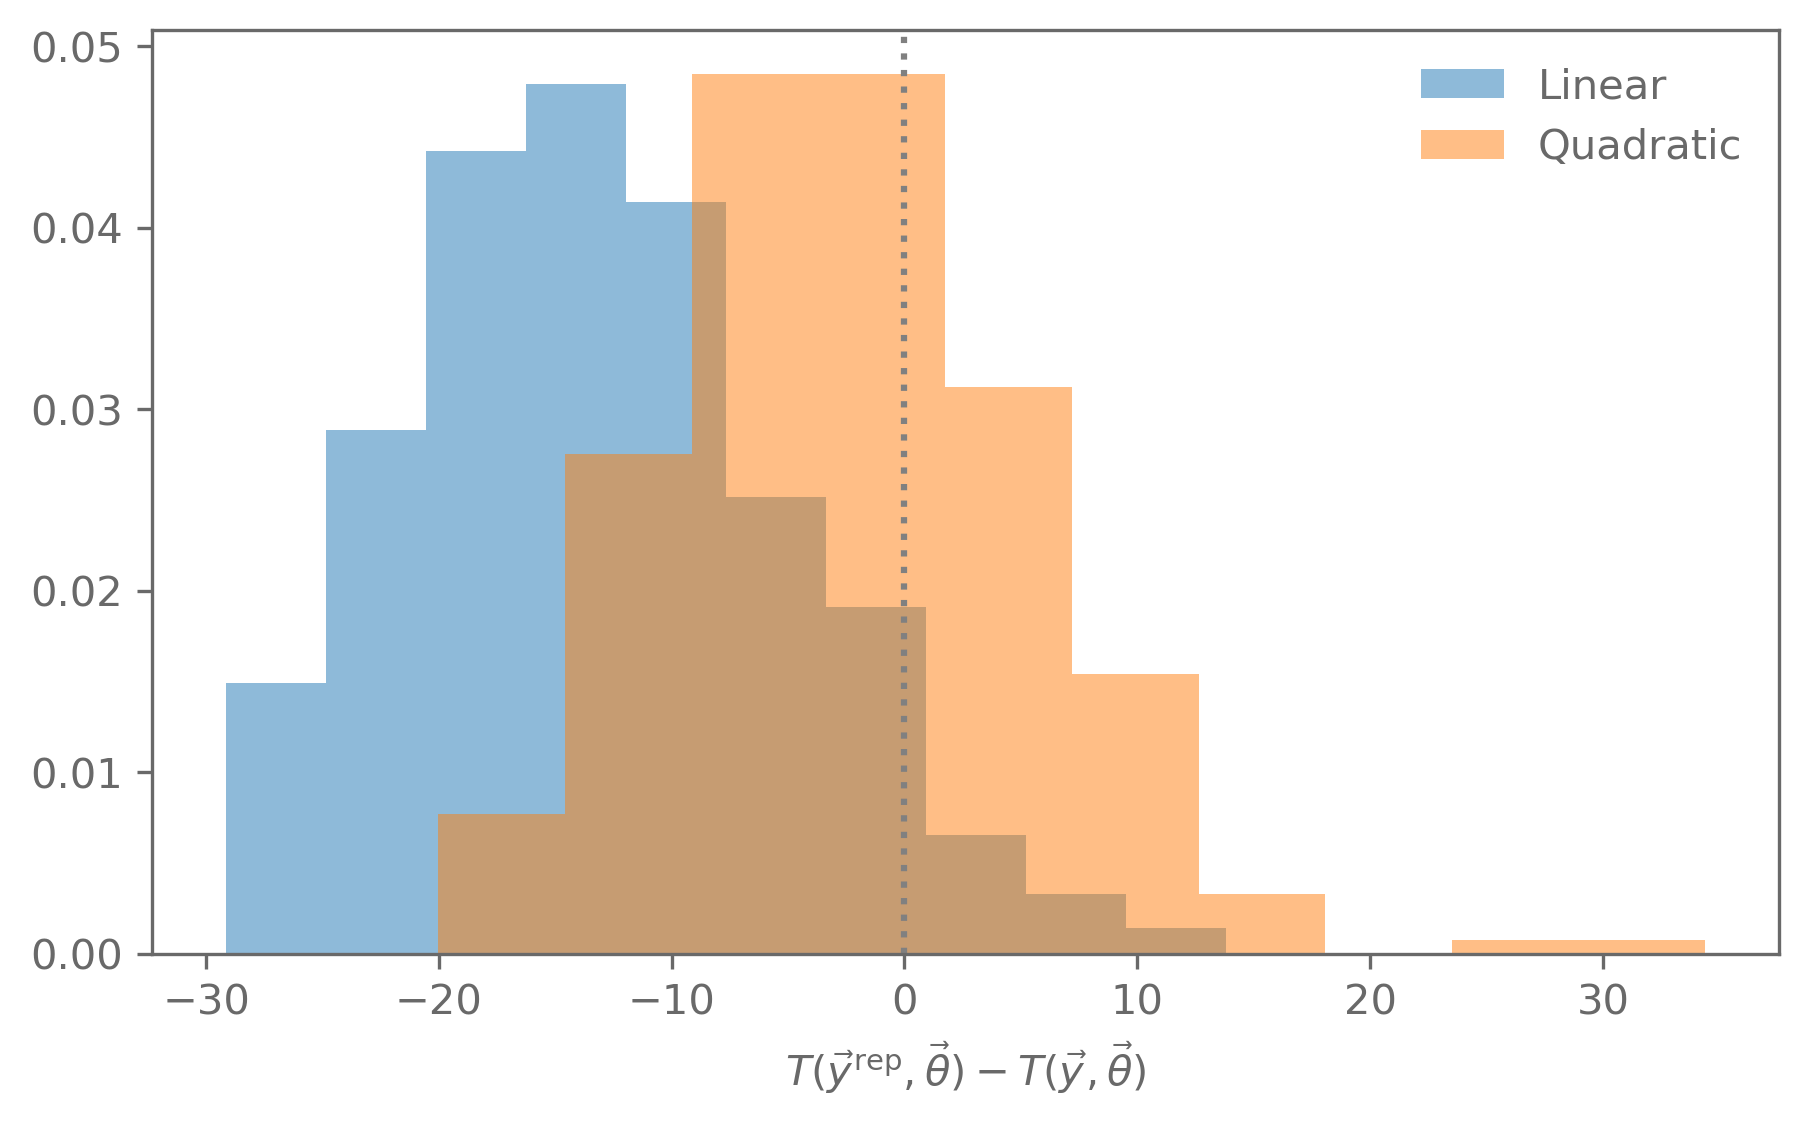

In [66]:
plt.hist(t_rep_lin - t_data_lin, density=True, alpha=0.5, label="Linear")
plt.hist(t_rep_quad - t_data_quad, density=True, alpha=0.5, label="Quadratic")
plt.axvline(0, ls=":", color="grey")
plt.legend(frameon=False)
plt.xlabel(r"$T(\vec y^\mathrm{rep}, \vec\theta) - T(\vec y, \vec\theta)$");

### Clicker

What is the difference between a chi-square test and a posterior predictive check with a chi-square test statistic?
- A chi-square test measures predictive accuracy, while a posterior predictive check measures overfitting.
- In the chi-square test, the chi-square statistic always decreases with more parameters, but in a posterior predictive check, it increases as parameters are added.
- The chi-square test assumes Gaussianity whereas the PPC with a chi-square test statistic doesn’t.
- The chi-square test uses a point estimate for model parameters, while the posterior predictive check accounts for the full uncertainty in the posterior.

# Model comparison

After we have checked that the model is describing the data well, we might want to compare different models.

We have already discussed the Bayes ratio $\frac{p(y| M_1)}{p(y| M_2)}$ as a tool to decide between models.

Here we look at two other approaches to compare models that do not need computing the evidence.

## Deviance information criterion (DIC)

The deviance information criterion (DIC) is defined as
$$
    \text{DIC} = -2\left(\log p(\vec y |\vec\theta^*) - p_\mathrm{D}\right) \ ,
$$
with the number of effective model parameters
$$
    p_\mathrm{D} = 2\left(\log p(\vec y |\vec\theta^*) - \E_{p(\theta |\vec y)}[\log p(\vec y |\vec\theta)]\right)\ ,
$$
where the last term is the mean of the log likelihood over the posterior.



An alternative estimate of the number of effective model parameteres is
$$
    p_\mathrm{V} = 2\Var_{p(\theta |\vec y)}[\log p(\vec y |\vec\theta)]\,.
$$


$$
    \text{DIC} = -2\left(\log p(\vec y |\vec\theta^*) - p_\mathrm{D}\right) \ ,
$$

Interpretation: log-likelihood at the point of the best-fit parameter $\vec\theta^*$ minus the number of parameters in the model.

The better the fit, the higher the likelihood. The DIC is lower for better models, but adding more parameters that do not significantly improve the likelihood are penalised. 

Why are $p_\mathrm{D}$ and $p_\mathrm{V}$ estimates of the effective number of model parameters?

Let us consider the case where the likelihood, posterior, and prior are approximately Gaussian, with $d$ model parameters. 

Define $D(\theta) = -2\log p(\vec y |\vec\theta)$. First, expand around the best-fit $\vec\theta^*$:
$$
    D(\theta) \approx D(\theta^*) + (\theta - \theta^*)D'_{\theta^*} + \frac{1}{2}(\theta - \theta^*)^T D''_{\theta^*}(\theta - \theta^*)\,,
$$
where $D'_{\theta^*}$ and $D''_{\theta^*}$ are the first and second derivatives of $D$ with respect to $\vec\theta$ at $\vec\theta^*$.



Then take the expectation with respect to the posterior:
$$
\begin{split}
    \E[D(\theta)] &\approx D(\theta^*) + E[(\theta - \theta^*)^T D''_{\theta^*}(\theta - \theta^*)] \\
    &= D(\theta^*) + \mathrm{tr}(D''_{\theta^*}E[(\theta - \theta^*)(\theta - \theta^*)^T ]) \\
    &= D(\theta^*) + \mathrm{tr}(D''_{\theta^*}\Sigma_{p(\theta|y)})\,,
\end{split}
$$
where $\Sigma_{p(\theta|y)}$ is the covariance of the posterior.



Remember the definition of $p_\mathrm{D}$:
$$
    p_\mathrm{D} = D(\theta^*) - \E[D(\theta)] \approx \mathrm{tr}(D''_{\theta^*}\Sigma_{p(\theta|y)})
$$

We can write $D(\theta)$ in terms of the posterior and prior using Bayes' theorem:
$$
    D(\theta) = -2\log p(\vec y |\vec\theta) = -2 \log\left( \frac{p(\theta |\vec y)}{p(\vec\theta)} p(\vec y)\right)\,.
$$



The Hessian of $D''_{\theta^*}$ can now be written as
$$
    D''_{\theta^*, ij} = -2 \frac{\partial^2}{\partial\theta_i\partial\theta_j}\log p(\theta |\vec y) + 2 \frac{\partial^2}{\partial\theta_i\partial\theta_j}\log p(\theta) \approx \Sigma_{p(\theta|y)}^{-1} -  \Sigma_{p(\theta)}^{-1}\,,
$$
where we assumed the posterior and prior are Gaussian, with covariances $\Sigma_{p(\theta|y)}$ and $\Sigma_{p(\theta)}$.



Putting things together, we find the effective number of model parameters
$$
    p_\mathrm{D} \approx \mathrm{tr}(D''_{\theta^*}\Sigma_{p(\theta|y)}) \approx d - \mathrm{tr}(\Sigma_{p(\theta)}^{-1}\Sigma_{p(\theta|y)})
$$
This behaves as we would hope:
- In the case where the prior is very uninformative ($\Sigma_{p(\theta)}\to\infty$) all parameters are constrained by the data: $p_\mathrm{D} = d$. 
- In the case where the prior is the same as the posterior ($\Sigma_{p(\theta)} = \Sigma_{p(\theta|y)}$), none of the parameters are constrained by the data: $p_\mathrm{D} = 0$.

Implement the DIC:

In [49]:
def DIC(theta_star, theta_samples, log_likelihood):
    # Compute log likelihood at theta_star and the samples theta_i
    log_likelihood_star = log_likelihood(theta_star)
    log_likelihood_samples = np.array(
        [log_likelihood(theta) for theta in theta_samples]
    )
    p_D = 2*(log_likelihood_star - np.mean(log_likelihood_samples))
    p_V = 2*np.var(log_likelihood_samples)
    return -2*(log_likelihood_star - p_D), p_D, p_V

In [50]:
DIC_lin, p_D_lin, p_V_lin = DIC(
    theta_star=results_linear["MAP"],
    theta_samples=results_linear["PPD_params"],
    log_likelihood=lambda theta: log_likelihood_lin(y, theta, x, y_err)
)

DIC_quad, p_D_quad, p_V_quad = DIC(
    theta_star=results_quadratic["MAP"],
    theta_samples=results_quadratic["PPD_params"],
    log_likelihood=lambda theta: log_likelihood_quad(y, theta, x, y_err)
)
print(f"Linear: DIC = {DIC_lin:.1f}, p_D = {p_D_lin:.1f}, p_V = {p_V_lin:.1f}")
print(f"Quadratic: DIC = {DIC_quad:.1f}, p_D = {p_D_quad:.1f}, p_V = {p_V_quad:.1f}")

Linear: DIC = -60.2, p_D = 1.9, p_V = 2.0
Quadratic: DIC = -69.4, p_D = 3.1, p_V = 2.9


The quadratic model has a lower DIC and is therefore preferred. The much better fit is not offset by the larger number of parameters.

### Clicker

How does the Bayes factor conceptually differ from DIC when comparing models?
- The Bayes factor has a probabilistic interpretation whereas the DIC hasn’t, it is just a quantitative criterion.
- The Bayes factor is more sensitive to the number of data points than DIC.
- The Bayes factor incorporates prior information, while DIC relies purely on the likelihood.
- DIC focuses on the posterior distribution, while the Bayes factor focuses on point estimates of parameters.

## WAIC

The DIC is easy to calculate but has the downside that it relies on a point estimate for $\vec\theta^*$. A more Bayesian information criterion is the Watanabe-Akaike or widely applicable information criterion (WAIC).

It assumes we can partition the data into $M$ partitions, for example the $n$ entries $y_i$ in the data vector $\vec y$. Then the log pointwise predictive density (lppd) is
$$
    \text{lppd} = \sum_{i=1}^n\log\E[p(y_i |\vec\theta)] = \sum_{i=1}^n\log\int p(y_i |\vec\theta)p(\vec\theta|\vec y)\dd \theta^n
$$



The number of parameters are estimated as
$$
    p_\mathrm{WAIC} = \sum_{i=1}^n \Var[\log p(\vec y_i |\vec\theta)]
$$

Finally, the WAIC is calculated as
$$
    \text{WAIC} = -2\left(\text{lppd} - p_\mathrm{WAIC}\right)
$$

In [16]:
def WAIC(theta_samples, log_likelihood, y_partitions, x_partitions, y_err_partitons):
    # Compute the log likelihood for each partition separately
    pointwise_log_likelihood_samples = np.array(
        [[log_likelihood(y_partitions[i], theta, x_partitions[i], y_err_partitons[i])
            for i in range(len(y_partitions))] 
         for theta in theta_samples]
    )

    # Compute the lppd and p_waic for each partition
    lppd = np.log(np.mean(np.exp(pointwise_log_likelihood_samples), axis=0))
    p_waic = np.var(pointwise_log_likelihood_samples, axis=0)
    # Check if the any of the terms in p_waic are too large, which indicates
    # a problem
    if np.any(p_waic > 0.4):
        print(f"Warning: Var[log p(y_i|theta)] > 0.4 for data points "
              f"{np.argwhere(p_waic > 0.4)}. p_WAIC unreliable!")
    # Sum up the partitions
    lppd = np.sum(lppd)
    p_waic = np.sum(p_waic)

    return -2*(lppd - p_waic), p_waic, pointwise_log_likelihood_samples

In [73]:
WAIC_lin, p_WAIC_lin, pointwise_log_likelihood_samples_lin = WAIC(
    theta_samples=results_linear["PPD_params"],
    log_likelihood=log_likelihood_lin,
    y_partitions=y,
    x_partitions=x,
    y_err_partitons=y_err
)

WAIC_quad, p_WAIC_quad, pointwise_log_likelihood_samples_quad = WAIC(
    theta_samples=results_quadratic["PPD_params"],
    log_likelihood=log_likelihood_quad,
    y_partitions=y,
    x_partitions=x,
    y_err_partitons=y_err
)
print(f"Linear: WAIC = {WAIC_lin:.1f}, p_WAIC = {p_WAIC_lin:.1f}")
print(f"Quadratic: WAIC = {WAIC_quad:.1f}, p_WAIC = {p_WAIC_quad:.1f}")

 [29]]. p_WAIC unreliable!
 [29]]. p_WAIC unreliable!
Linear: WAIC = -57.7, p_WAIC = 4.0
Quadratic: WAIC = -67.7, p_WAIC = 4.2


The WAIC also prefers the quadratic model. Warnings and oddly high number of parameters should give us pause, however.

## Cross-validation

Both the DIC and WAIC are approximations to leave-one-out cross-validation (LOO-CV). 

The idea behind cross-validation is to split the data into a training set $y_\mathrm{train}$ and a holdout set $y_\mathrm{holdout}$.

We then evaluate the PPD (using the posterior $p(\theta | y_\mathrm{train})$) at $y_\mathrm{holdout}$.

This checks if the model can predict each data point given all the other data points.

This is a very clean apporach to model checking but it usually assumes that there are $n$ i.i.d. data points, or at least that the data can be partitioned as such. For correlated data, that might not be the case.


More specifically, we split the data into $n$ partions and for each compute
$$
    \log \int p(y_{i} | \theta)p(\theta | y_{(-i)}) \dd \theta\ ,
$$
where $y_i$ is the partion $i$ of the data and $y_{(-i)}$ is the data without the partion $i$.

This becomes computationally expensive quickly, since for each partion we need to create samples from the posterior $p(\theta | y_{(-i)})$. It also explicitly requires the data to be able to be split into partitions, which might be difficult for structured or dependent data.

A sophisticated approximation to LOO-CV that avoids recalculating the posterior for the partions is implemented in the package `arviz`. It also implements WAIC and other statistical diagnostics, for example for MCMC.

In [18]:
import arviz

inference_data_lin = arviz.from_dict(
    posterior={"lin": results_linear["PPD_params"][None, ...]},
    log_likelihood={"lin": pointwise_log_likelihood_samples_lin[None, ...]},
)

inference_data_quad = arviz.from_dict(
    posterior={"quad": results_quadratic["PPD_params"][None, ...]},
    log_likelihood={"quad": pointwise_log_likelihood_samples_quad[None, ...]},
)
arviz.compare({"lin": inference_data_lin, "quad": inference_data_quad}, ic="loo", scale="deviance")

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
quad,0,-66.855284,4.660655,0.000000,0.793203,8.325738,0.000000,False,deviance
lin,1,-57.497176,4.131351,9.358108,0.206797,14.849195,9.453856,False,deviance


### Clicker

How does LOO-CV conceptually differ from WAIC or DIC when comparing models?
- LOO-CV is less computationally intensive than WAIC or DIC, making it more suitable for large datasets.
- WAIC and DIC rely on resampling methods, while LOO-CV only uses a point estimate from the posterior distribution.
- LOO-CV penalizes models more heavily for complexity than WAIC or DIC, which tend to overfit the data.
- LOO-CV directly measures how well the model predicts unseen data by holding out one data point at a time, while WAIC and DIC estimate predictive performance using the entire dataset.

## Supernovae

Let us apply the goodness-of-fit tests and DIC to the supernova example!

In [20]:
import sys
sys.path.append("../projects/dark_energy_SN/")
from likelihood import PantheonSH0ESLikelihood

import astropy

# This holds the data and takes care of the modelling
pantheon_sh0es = PantheonSH0ESLikelihood(
    data_file_name="../projects/dark_energy_SN/data/pantheon_sh0es.npz",
)

# Pull out data for our simplified analysis
z_data = pantheon_sh0es.z_CMB
data = pantheon_sh0es.magnitude_data
data_error_bar = pantheon_sh0es.magnitude_data_error
inv_covariance = np.linalg.inv(pantheon_sh0es.covariance_no_calibrator)

In [21]:
def compute_distance_modulus(cosmology, z):
    luminosity_distance = cosmology.luminosity_distance(z)
    luminosity_distance = (luminosity_distance/astropy.units.Mpc).value

    mu = 5.0*np.log10(luminosity_distance*1e6/10)
    return mu

def LCDM_distance_modulus_model(theta, z):
    H_0, Omega_m, Omega_de, M = theta
    cosmology = astropy.cosmology.LambdaCDM(H0=H_0, Om0=Omega_m, Ode0=Omega_de)

    prediction = compute_distance_modulus(cosmology, z)
    prediction += M

    return prediction

In [22]:
def flat_LCDM_distance_modulus_model(theta, z):
    H_0, Omega_m, M = theta
    cosmology = astropy.cosmology.FlatLambdaCDM(H0=H_0, Om0=Omega_m)

    prediction = compute_distance_modulus(cosmology, z)
    prediction += M

    return prediction

In [23]:
# From the SH0ES analysis Riess+2022 (https://arxiv.org/abs/2112.04510)
H_0_prior = scipy.stats.norm(loc=73.04, scale=1.04)

# scipy.stats.uniform defines the interval as [loc, loc+scale]
Omega_m_prior = scipy.stats.uniform(loc=0.1, scale=0.8)
Omega_de_prior = scipy.stats.uniform(loc=0.1, scale=0.8)
M_prior = scipy.stats.uniform(loc=-20, scale=2)

In [24]:
def make_likelihood(model):
    def log_likelihood(theta):
        r = data - model(theta, z=z_data)
        return -0.5 * r @ inv_covariance @ r
    
    L = np.linalg.cholesky(pantheon_sh0es.covariance_no_calibrator)

    def sample_from_likelihood(theta):
        # scipy.stats.multivariate_normal is VERY slow for the 
        # large covariance we have, so we sample it ourselves
        mu = model(theta, z=z_data)
        sample = L @ np.random.normal(size=mu.size) + mu
        return sample
    
    return log_likelihood, sample_from_likelihood

In [25]:
log_likelihood_LCDM, sample_from_likelihood_LCDM = make_likelihood(LCDM_distance_modulus_model)

def log_prior_lcdm(theta):
    H_0, Omega_m, Omega_de, M = theta
    return H_0_prior.logpdf(H_0) + Omega_m_prior.logpdf(Omega_m) + Omega_de_prior.logpdf(Omega_de) + M_prior.logpdf(M)

def log_posterior_lcdm(theta):
    p = log_prior_lcdm(theta)
    if not np.isfinite(p):
        return -np.inf
    return log_likelihood_LCDM(theta) + p

theta_init_lcdm = np.array([80.0, 0.2, 0.5, -19.5])

MAP_result = scipy.optimize.minimize(
    fun=lambda theta: -log_posterior_lcdm(theta),
    x0=theta_init_lcdm,
    method="Nelder-Mead",
)
theta_MAP_lcdm = MAP_result.x

In [26]:
log_likelihood_flat_LCDM, sample_from_likelihood_flat_LCDM = make_likelihood(flat_LCDM_distance_modulus_model)

def log_prior_flat_lcdm(theta):
    H_0, Omega_m, M = theta
    return H_0_prior.logpdf(H_0) + Omega_m_prior.logpdf(Omega_m) + M_prior.logpdf(M)

def log_posterior_flat_lcdm(theta):
    p = log_prior_flat_lcdm(theta)
    if not np.isfinite(p):
        return -np.inf
    return log_likelihood_flat_LCDM(theta) + p

theta_init_flat_lcdm = np.array([80.0, 0.2, -19.5])

MAP_result = scipy.optimize.minimize(
    fun=lambda theta: -log_posterior_flat_lcdm(theta),
    x0=theta_init_flat_lcdm,
    method="Nelder-Mead",
)
theta_MAP_flat_lcdm = MAP_result.x


First, the chi-squared test:

In [30]:
n_data = len(data)
n_param_flat_lcdm = 3
n_param_lcdm = 4

chi_squared_flat_lcdm = -2*log_likelihood_flat_LCDM(theta_MAP_flat_lcdm)
chi_squared_lcdm = -2*log_likelihood_LCDM(theta_MAP_lcdm)

PTE_flat_lcdm = scipy.stats.chi2(df=n_data - n_param_flat_lcdm).sf(chi_squared_linear)
PTE_lcdm = scipy.stats.chi2(df=n_data - n_param_lcdm).sf(chi_squared_quadratic)

print(f"Flat LCDM: χ²={chi_squared_flat_lcdm:.2f}, "
      f"ndof={n_data}-{n_param_flat_lcdm}, PTE={PTE_flat_lcdm:.3f}")

print(f"LCDM: χ²={chi_squared_lcdm:.2f}, "
      f"ndof={n_data}-{n_param_lcdm}, PTE={PTE_lcdm:.3f}")

Flat LCDM: χ²=1441.69, ndof=1580-3, PTE=1.000
LCDM: χ²=1441.41, ndof=1580-4, PTE=1.000


The $\chi^2$ values are too low for the number of data points. This suggests that the data uncertainties are overestimated. Let us run an MCMC chain (with `zeus` in this case) and look at the PPD test statistic.

In [45]:
import zeus

n_param = 4
n_walker = 12
n_step = 100

start_point = np.random.normal(size=(n_walker, n_param), loc=theta_MAP_lcdm, scale=(0.1, 0.01, 0.01, 0.1))
 
sampler_lcdm = zeus.EnsembleSampler(nwalkers=n_walker, ndim=n_param, logprob_fn=log_posterior_lcdm)

sampler_lcdm.run_mcmc(start=start_point, nsteps=n_step, progress=True)

print("Integrated autocorrelation time:", zeus.AutoCorrTime(sampler_lcdm.get_chain()))

chain_lcdm = sampler_lcdm.get_chain(discard=50, flat=True)

Initialising ensemble of 12 walkers...
Sampling progress : 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]

Integrated autocorrelation time: [5.44045274 4.71651602 5.50330958 7.05414514]


In [43]:
n_param = 3
n_walker = 12
n_step = 100

start_point = np.random.normal(size=(n_walker, n_param), loc=theta_MAP_flat_lcdm, scale=(0.1, 0.01, 0.1))
 
sampler_flat_lcdm = zeus.EnsembleSampler(nwalkers=n_walker, ndim=n_param, logprob_fn=log_posterior_flat_lcdm)

sampler_flat_lcdm.run_mcmc(start=start_point, nsteps=n_step, progress=True)

print("Integrated autocorrelation time:", zeus.AutoCorrTime(sampler_flat_lcdm.get_chain()))

chain_flat_lcdm = sampler_flat_lcdm.get_chain(discard=50, flat=True)

Initialising ensemble of 12 walkers...
Sampling progress : 100%|██████████| 100/100 [00:32<00:00,  3.10it/s]

Integrated autocorrelation time: [8.8954404  3.34617029 8.53328505]


We use the $\chi^2$ as the test statistic again:

In [67]:
def test_statistic(data, mu):
    r = data - mu
    return r @ inv_covariance @ r

T_rep_flat_lcdm = np.array([
    test_statistic(
        data=sample_from_likelihood_flat_LCDM(p),
        mu=flat_LCDM_distance_modulus_model(p, z_data)
    ) for p in chain_flat_lcdm
])
T_flat_lcdm = np.array([
    test_statistic(
        data=data,
        mu=flat_LCDM_distance_modulus_model(p, z_data)
    ) for p in chain_flat_lcdm
])

ppd_pte_flat_lcdm = (T_rep_flat_lcdm > T_flat_lcdm).sum()/T_rep_flat_lcdm.size

print(f"Flat LCDM PPD PTE: {ppd_pte_flat_lcdm:.3f}")

Flat LCDM PPD PTE: 0.995


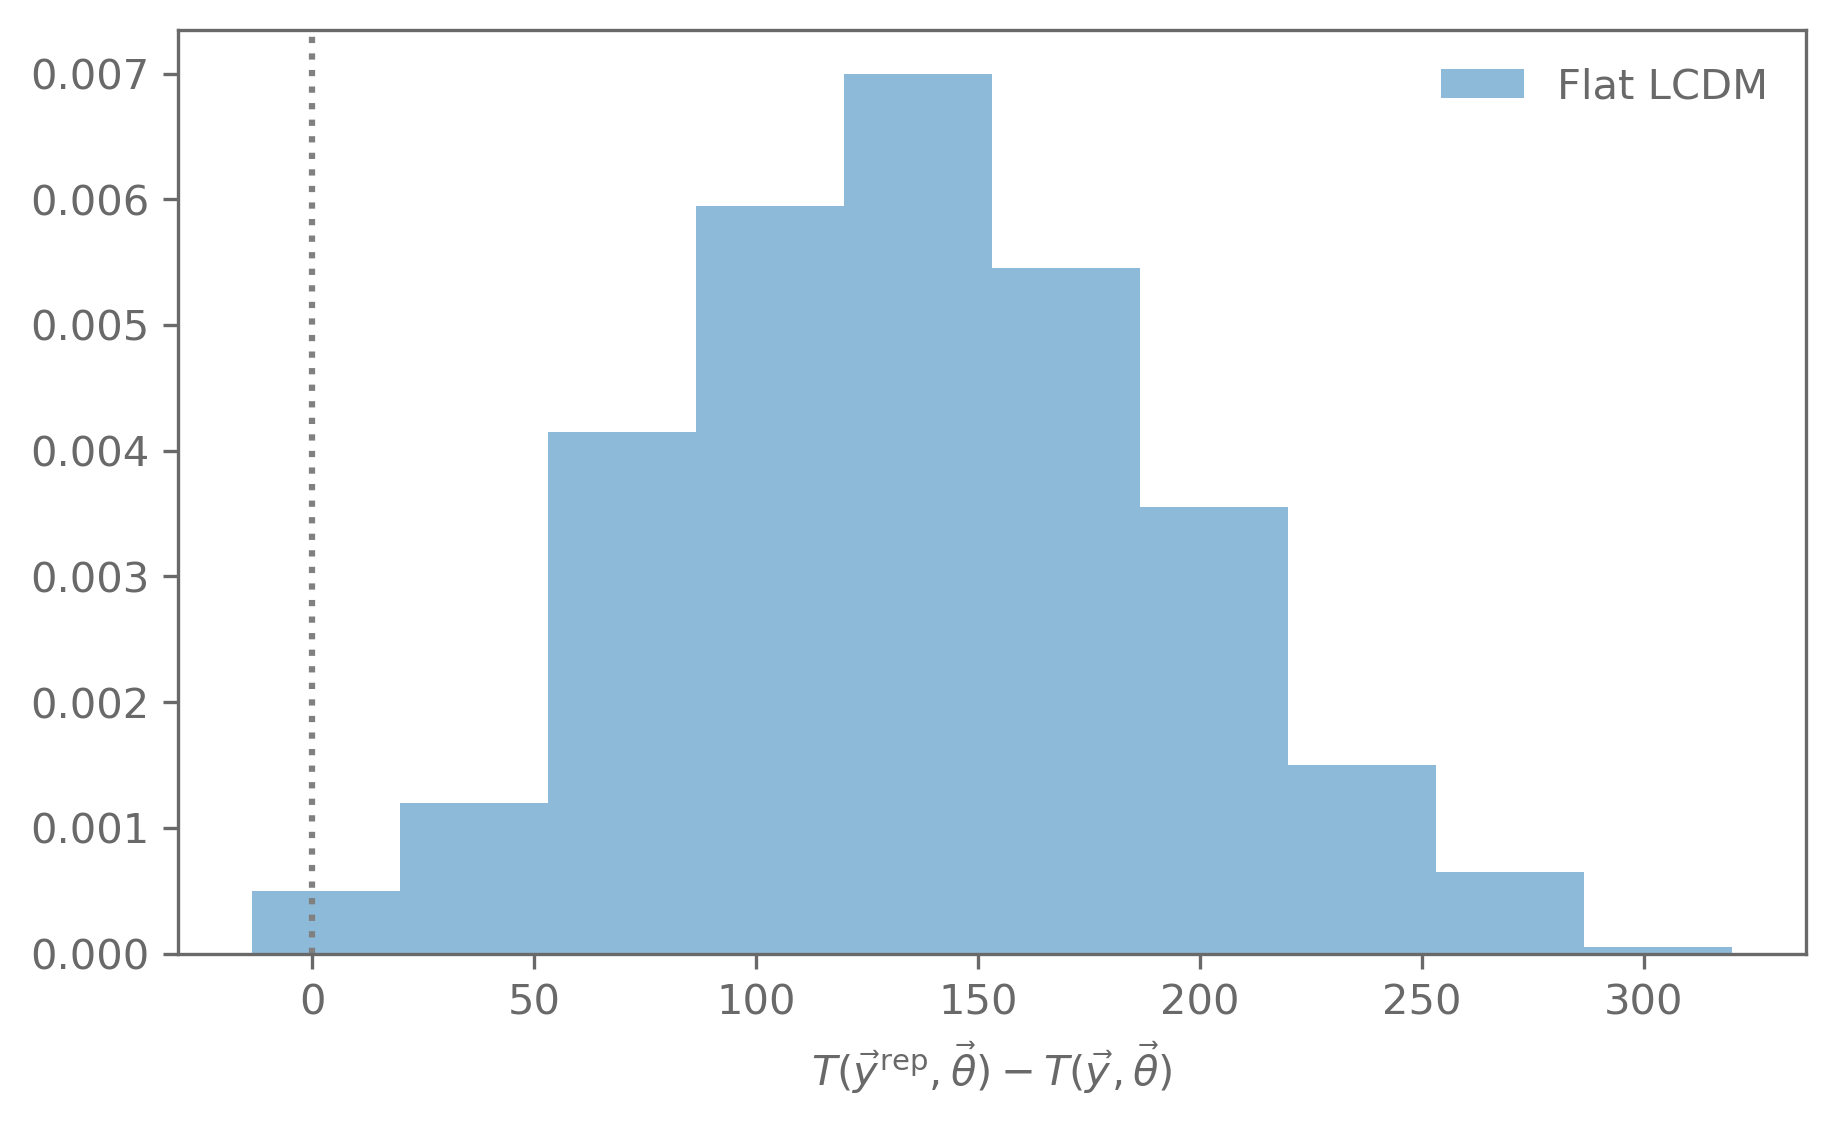

In [ ]:
plt.hist(T_rep_flat_lcdm - T_flat_lcdm, density=True, alpha=0.5, label="Flat LCDM")
plt.axvline(0, ls=":", color="grey")
plt.legend(frameon=False)
plt.xlabel(r"$T(\vec y^\mathrm{rep}, \vec\theta) - T(\vec y, \vec\theta)$");

This also indicates that the observed data do not scatter as much as our model suggests. 

Something is not right. The first suspect is the data covariance.

We used the STAT+SYS covariance here. That means the covariance includes the systematic uncertainty on top of the statistical uncertainty. This could explain the very high PTE on the test statistic.

We already compared the flat and non-flat $\Lambda\text{CDM}$ models using the Bayes' ratio. Now er see what the DIC tells us:

In [51]:
DIC_flat_lcdm, p_D_flat_lcdm, p_V_flat_lcdm = DIC(
    theta_star=theta_MAP_flat_lcdm,
    theta_samples=chain_flat_lcdm,
    log_likelihood=log_likelihood_flat_LCDM
)
DIC_lcdm, p_D_lcdm, p_V_lcdm = DIC(
    theta_star=theta_MAP_lcdm,
    theta_samples=chain_lcdm,
    log_likelihood=log_likelihood_LCDM
)

print(f"Flat LCDM: DIC = {DIC_flat_lcdm:.1f}, p_D = {p_D_flat_lcdm:.1f}, p_V = {p_V_flat_lcdm:.1f}")
print(f"LCDM: DIC = {DIC_lcdm:.1f}, p_D = {p_D_lcdm:.1f}, p_V = {p_V_lcdm:.1f}")

Flat LCDM: DIC = 1446.1, p_D = 2.2, p_V = 2.0
LCDM: DIC = 1447.5, p_D = 3.1, p_V = 3.5


The DIC slightly prefers the simpler, flat $\Lambda\text{CDM}$ model.

We also see that the estimates of the number of model parameters makes sense: the flat $\Lambda$CDM model has 3 parameters ($H_0$, $\Omega_\mathrm{m}$, $M$) but $H_0$ is completly constrained by the prior. So effectively, the data can only inform $\approx 2$ parameters.

The non-flat model has 4 parameters but again, $H_0$ is completly constrained by the prior, so we are left with $\approx 3$ effective free parameters.

## Exercise

Reproduce the chi-squared and PPD-based test with your own analysis code.

Show that for a Gaussian posterior with a wide and uniform prior, the estimate $p_\mathrm{V}$ of the effective number of free parameters reduces to the dimensionality of the Gaussian.

Try a cubic model. What are the DIC, WAIC, and Bayes factor?